<a href="https://colab.research.google.com/github/alyahoang99/GANs/blob/main/smart_meter_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Smart meter data in 15-minute resolution. It includes four households, each with two separate smart meters. All households have a heat pump installed for heating purposes, which is measured by one separate smart meter. All other appliances are measured by the second smart meter. In addition to the smart meter data, temperature measurements being loaded from a nearby weather station. From Nov 2019 to Aug 2022.

In [ ]:
!pip install ruptures
!pip install saxpy
!pip install tsfresh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.0/179.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.0/244.0 kB 18.5 MB/s eta 0:00:00
  Created wheel for saxpy: filename=saxpy-1.0.1.dev167-py3-none-any.whl size=17689 sha256=b1155778c2a274460d9bc1b458e162d52472ebce7d2cf91befa572992fa69274
  Stored in directory: /root/.cache/pip/wheels/c3/ec/33/aaf899fece5f2d8d9cf38f082b5cb04249bbd9a8c243762231
Successfully built saxpy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 58.0 MB/s eta 0:00:00


In [ ]:
# basic packages
import pandas as pd
import numpy as np
import datetime as dt
from pytz import timezone
import urllib
import os
import math
from scipy import stats
from scipy.signal import find_peaks, spectrogram

# packages for visualizations
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# sklearn packages
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import KMeans

# set global variables about the time-zone (used by pandas and matplotlib)
TZ_LOCAL = 'Europe/London'
plt.rcParams['timezone'] = TZ_LOCAL
plt.rcParams['figure.dpi']= 100

In [ ]:
# ---------------------
# DEFINE HELPER METHODS
# ---------------------

def load_remote_data(url, filename, index_col):
  '''
    Loads the data from an URL and file name.
    Args:
      url: Google Drive URL to file
      filename: name of file
      index_col: the column name to set the index to
    Returns:
      data frame
  '''
  # if the data is not yet downloaded, retrieve it by URL
  if not os.path.isfile(filename):
    urllib.request.urlretrieve(url, filename)

  # load data with pandas
  df = pd.read_csv(filename, index_col=index_col)
  return df

def handle_timezones(df_smd, df_weather_daily, df_weather_hourly):
  '''
    Sets local timezones on data frames of smart meter and weather data.
    Args:
      df_smd: data frame holding smart meter data
      df_weather_daily: data frame holding daily temperature readings
      df_weather_hourly: data frame holding hourly temperature readings
  '''
  #df_smd.index = pd.to_datetime(df_smd.index, format='%Y-%m-%d %H:%M:%S').tz_convert(TZ_LOCAL)
  df_weather_daily.index = pd.to_datetime(df_weather_daily.index, format='%Y-%m-%d').tz_localize('UTC')
  df_weather_hourly.index = pd.to_datetime(df_weather_hourly.index, format='%Y-%m-%d %H:%M:%S').tz_localize('UTC').tz_convert(TZ_LOCAL)

def get_household_file_ids(customer_number):
  '''
    For each customer defines the file-IDs in Google Drive.
    Args:
      customer_number: integer between 1 and 4 to identify the four example customers
    Returns:
      dictionary with file IDs for smart meter data, daily weather, and hourly weather
  '''
  return {
      1 : {'customer1_smd' : '1bQaj4Gu_rCHxKa1fQuu-yNp7ceCIrPbb', 'customer1_weather_daily' : '1qM2YguM7Ij3LHkPwplLSFQTEdYedjQ9y', 'customer1_weather_hourly' : '1qjDkM3TPmaeNEPHWMPgCkobbRVLpgcxc'},
      2 : {'customer2_smd' : '1swUbaR1960i46AGXHp1ZL3KV1uI44Kd8', 'customer2_weather_daily' : '1WQUAlz4AsMqjsg33rwoRyPko9qNHkiMz', 'customer2_weather_hourly' : '1b_Nk0gYKESw5EeBImICbg7uiIpNOpXe6'},
      3 : {'customer3_smd' : '1Cmv_oRtHx5PlHadaXhA2aqmmEOpNCnqB', 'customer3_weather_daily' : '15ErtjTLiKKMaBOv68HTgxbZ5fPEnsswF', 'customer3_weather_hourly' : '1nYOv-55n2DFpQYbcS88V2zL8-xCLlHr6'},
      4 : {'customer4_smd' : '1keacAOQGpPFYVM2MhQdaO-3c0DVtcsXl', 'customer4_weather_daily' : '1EddXm10v26MGlb0pYJgaaqemCTLGtlc_', 'customer4_weather_hourly' : '1PXdmlEZKt0mNbLJ7fWReJgmRPOAVh6EM'}
  }[customer_number]

def get_download_information(customer_number):
  '''
    For each customer get the file names and URLS for data download from Google Drive.
    Args:
      customer_number: integer between 1 and 4 to identify the four example customers
    Returns:
      dictionary with file names as keys and URLs as values
  '''
  d = {}
  for k, v in get_household_file_ids(customer_number).items():
    d[k+'.csv'] = 'https://drive.google.com/uc?id={}&export=download'.format(v)
  return d

def load_customer_data(customer_number):
  '''
    Loads the smart meter data, daily and hourly temperature readings for each of the four customers.
    Args:
      customer_number: integer between 1 and 4 to identify the four example customers
    Returns:
      sequence of df with smart meter, df with daily weather, df with hourly weather
  '''
  assert customer_number in range(1, 5), 'Customer number must be one of the following integers: 1, 2, 3, 4'
  d = get_download_information(customer_number)
  customer_id = 'customer{}_'.format(customer_number)

  # fetch data
  df_smd = load_remote_data(d[customer_id+'smd.csv'], customer_id+'smd.csv', 'Timestamp')
  df_weather_daily = load_remote_data(d[customer_id+'weather_daily.csv'], customer_id+'weather_daily.csv', 'date')
  df_weather_hourly = load_remote_data(d[customer_id+'weather_hourly.csv'], customer_id+'weather_hourly.csv', 'date_and_time')

  # handle time zones
  handle_timezones(df_smd, df_weather_daily, df_weather_hourly)

  return df_smd, df_weather_daily, df_weather_hourly

# ---------------------
# LOAD DATA
# ---------------------
customer = 4 # must be an integer - can be: 1, 2, 3, 4
df_smd, df_weather_daily, df_weather_hourly = load_customer_data(customer)
print('Loaded Data successfully for customer: {}'.format(customer))

Loaded Data successfully for customer: 4


In [ ]:
display(df_smd)

Value  Value_HeatPump  Value_OtherAppliances
Timestamp                                                              
2019-11-19 23:00:00+00:00  0.736           0.682                  0.054
2019-11-19 23:15:00+00:00  1.216           1.126                  0.090
2019-11-19 23:30:00+00:00  0.488           0.450                  0.038
2019-11-19 23:45:00+00:00  0.065           0.023                  0.042
2019-11-20 00:00:00+00:00  0.650           0.608                  0.042
...                          ...             ...                    ...
2022-08-31 20:45:00+00:00  0.052           0.000                  0.052
2022-08-31 21:00:00+00:00  0.035           0.000                  0.035
2022-08-31 21:15:00+00:00  0.031           0.000                  0.031
2022-08-31 21:30:00+00:00  0.042           0.000                  0.042
2022-08-31 21:45:00+00:00  0.043           0.000                  0.043

[97532 rows x 3 columns]

In [ ]:
df_smd.index

Index(['2019-11-19 23:00:00+00:00', '2019-11-19 23:15:00+00:00',
       '2019-11-19 23:30:00+00:00', '2019-11-19 23:45:00+00:00',
       '2019-11-20 00:00:00+00:00', '2019-11-20 00:15:00+00:00',
       '2019-11-20 00:30:00+00:00', '2019-11-20 00:45:00+00:00',
       '2019-11-20 01:00:00+00:00', '2019-11-20 01:15:00+00:00',
       ...
       '2022-08-31 19:30:00+00:00', '2022-08-31 19:45:00+00:00',
       '2022-08-31 20:00:00+00:00', '2022-08-31 20:15:00+00:00',
       '2022-08-31 20:30:00+00:00', '2022-08-31 20:45:00+00:00',
       '2022-08-31 21:00:00+00:00', '2022-08-31 21:15:00+00:00',
       '2022-08-31 21:30:00+00:00', '2022-08-31 21:45:00+00:00'],
      dtype='object', name='Timestamp', length=97532)

In [ ]:
df_smd.to_csv('loadconsumption.csv', index=True)

There are three columns of energy values that reflect the total consumption in kilowatt hours (kWh) for each 15-minute time interval:

- Value_HeatPump: Consumtion of the heat pump measured by one smart meter
- Value_OtherAppliances: All other consumption in the household measured by a second smart meter
- Value: Sum of both measurements reflecting the total consumption

In [ ]:
# daily and hourly weather data
display(df_weather_daily)
display(df_weather_hourly)

daily_mintemp  daily_maxtemp  daily_avgtemp
date                                                                  
2019-11-19 00:00:00+00:00              0              5              3
2019-11-20 00:00:00+00:00              2              7              4
2019-11-21 00:00:00+00:00              0              7              4
2019-11-22 00:00:00+00:00              0              6              4
2019-11-23 00:00:00+00:00              0              9              6
...                                  ...            ...            ...
2022-08-27 00:00:00+00:00             14             25             21
2022-08-28 00:00:00+00:00             13             24             20
2022-08-29 00:00:00+00:00             14             30             23
2022-08-30 00:00:00+00:00             16             20             19
2022-08-31 00:00:00+00:00             14             20             18

[1017 rows x 3 columns]

hourly_temperature
date_and_time                                
2019-11-19 00:00:00+00:00                   2
2019-11-19 01:00:00+00:00                   2
2019-11-19 02:00:00+00:00                   2
2019-11-19 03:00:00+00:00                   2
2019-11-19 04:00:00+00:00                   1
...                                       ...
2022-08-31 20:00:00+01:00                  18
2022-08-31 21:00:00+01:00                  18
2022-08-31 22:00:00+01:00                  17
2022-08-31 23:00:00+01:00                  17
2022-09-01 00:00:00+01:00                  16

[24408 rows x 1 columns]

In [ ]:
# load data of average daily profiles that we extracted for a few hundred households
url = 'https://drive.google.com/uc?id=1bKNvlzOmm9063D-rgxC2lX1W8J-3zE5M&export=download'
df_profiles = load_remote_data(url, 'profiles.csv', 'id')
display(df_profiles)

0      1      2      3      4      5  \
id                                                                           
05799b091d77acb8963bc4f189cbbc94  0.021  0.020  0.018  0.015  0.014  0.014   
057c30dbdc165d5dbc8dfaba85be5be7  0.566  0.557  0.799  0.908  0.822  0.770   
057c3fcbdcbfd97b9f8a50fb34f385d6  0.014  0.013  0.013  0.015  0.015  0.013   
057d57d2e17e556e76045ec53f58beb2  0.459  0.342  0.286  0.342  0.900  0.858   
057d990ed2aee058d63f15f30443f9e4  0.631  0.624  0.624  0.620  0.629  0.634   
...                                 ...    ...    ...    ...    ...    ...   
a42793c65fddea7c1f8228f8d4742635  0.086  0.126  0.101  0.084  0.093  0.082   
a427d8292c36aadbf48269008ce844b3  0.620  0.480  0.437  0.522  0.842  0.413   
a428b13bc581d14804c35c1f6b4169be  2.800  3.114  3.097  2.848  2.614  2.765   
a429fd879fe72a1660cbd364cced304b  0.463  0.482  0.457  0.443  0.497  0.480   
a42a3bba9dcf618c93b5cbb32da24a32  0.445  0.509  0.362  0.367  0.754  0.709   

                                      6      7      8      9  ...     86  \
id                                                            ...          
05799b091d77acb8963bc4f189cbbc94  0.013  0.012  0.013  0.013  ...  0.056   
057c30dbdc165d5dbc8dfaba85be5be7  0.658  0.609  0.934  0.931  ...  0.040   
057c3fcbdcbfd97b9f8a50fb34f385d6  0.013  0.015  0.015  0.014  ...  0.037   
057d57d2e17e556e76045ec53f58beb2  0.660  0.592  0.521  0.160  ...  0.113   
057d990ed2aee058d63f15f30443f9e4  0.632  0.634  0.638  0.632  ...  0.632   
...                                 ...    ...    ...    ...  ...    ...   
a42793c65fddea7c1f8228f8d4742635  0.082  0.087  0.079  0.075  ...  0.166   
a427d8292c36aadbf48269008ce844b3  0.439  0.400  0.406  0.353  ...  0.476   
a428b13bc581d14804c35c1f6b4169be  2.877  3.013  3.371  2.895  ...  0.441   
a429fd879fe72a1660cbd364cced304b  0.531  0.475  0.398  0.283  ...  0.137   
a42a3bba9dcf618c93b5cbb32da24a32  0.681  0.273  0.224  0.117  ...  0.130   

                                     87     88     89     90     91     92  \
id                                                                           
05799b091d77acb8963bc4f189cbbc94  0.054  0.044  0.040  0.037  0.033  0.029   
057c30dbdc165d5dbc8dfaba85be5be7  0.040  0.581  0.752  0.773  0.782  0.713   
057c3fcbdcbfd97b9f8a50fb34f385d6  0.034  0.033  0.034  0.032  0.029  0.025   
057d57d2e17e556e76045ec53f58beb2  0.180  0.727  0.723  0.719  0.529  0.431   
057d990ed2aee058d63f15f30443f9e4  0.618  0.612  0.617  0.624  0.622  0.624   
...                                 ...    ...    ...    ...    ...    ...   
a42793c65fddea7c1f8228f8d4742635  0.163  0.176  0.193  0.166  0.136  0.142   
a427d8292c36aadbf48269008ce844b3  0.593  0.847  0.579  0.580  0.537  0.632   
a428b13bc581d14804c35c1f6b4169be  0.629  0.974  1.541  1.746  1.910  1.880   
a429fd879fe72a1660cbd364cced304b  0.189  0.417  0.357  0.374  0.369  0.232   
a42a3bba9dcf618c93b5cbb32da24a32  0.119  0.118  0.127  0.108  0.132  0.452   

                                     93     94     95  
id                                                     
05799b091d77acb8963bc4f189cbbc94  0.024  0.023  0.022  
057c30dbdc165d5dbc8dfaba85be5be7  0.563  0.470  0.528  
057c3fcbdcbfd97b9f8a50fb34f385d6  0.024  0.021  0.018  
057d57d2e17e556e76045ec53f58beb2  0.471  0.488  0.518  
057d990ed2aee058d63f15f30443f9e4  0.634  0.632  0.636  
...                                 ...    ...    ...  
a42793c65fddea7c1f8228f8d4742635  0.068  0.058  0.069  
a427d8292c36aadbf48269008ce844b3  0.433  0.415  0.438  
a428b13bc581d14804c35c1f6b4169be  2.270  2.557  2.546  
a429fd879fe72a1660cbd364cced304b  0.249  0.273  0.282  
a42a3bba9dcf618c93b5cbb32da24a32  0.540  0.494  0.332  

[1000 rows x 96 columns]

calculate the mean consumption profile by averaging the consumption at each time of day over the entire period of measurements to get the insights

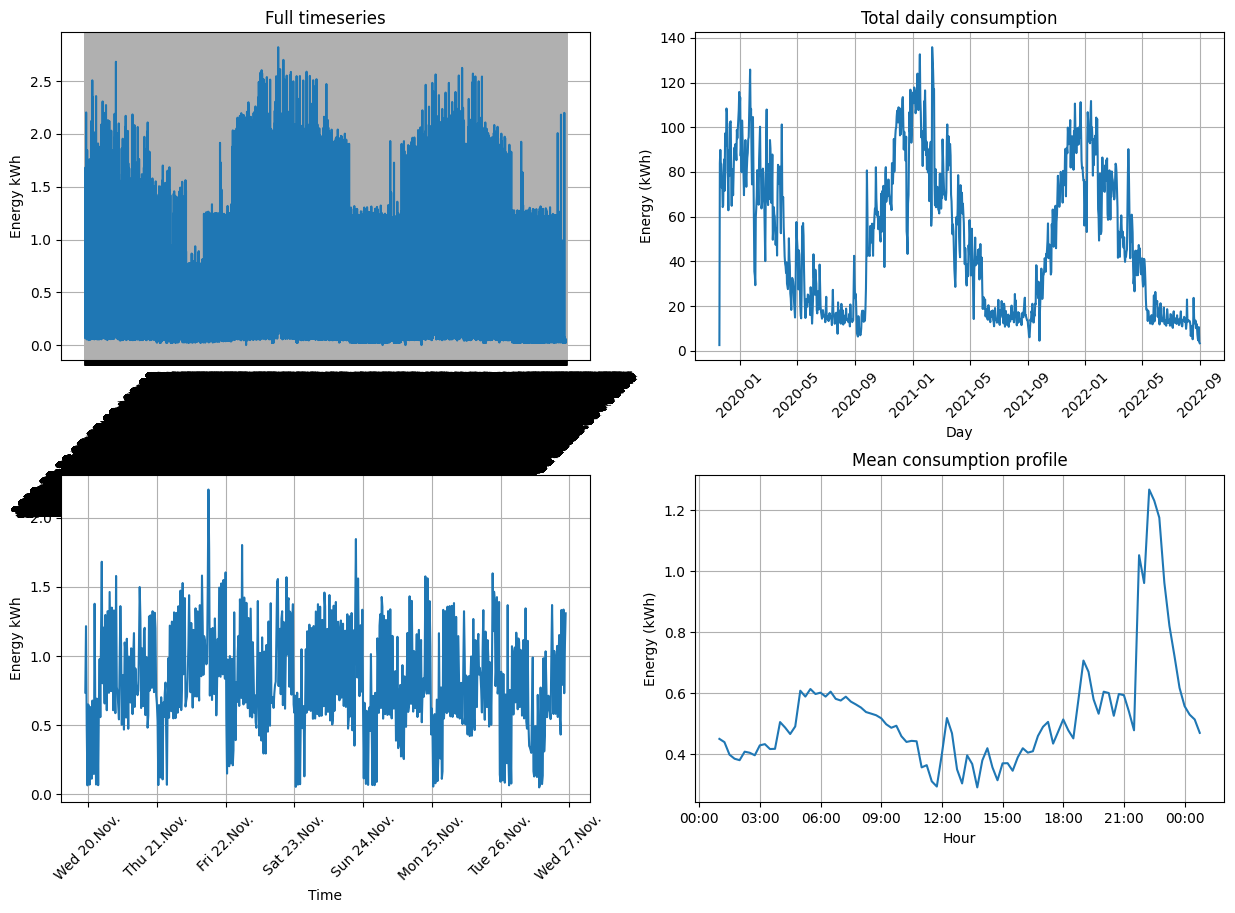

In [ ]:
import matplotlib.dates as mdates
from matplotlib.dates import AutoDateLocator, DateFormatter
import pandas as pd
import datetime as dt

# DEFINE HELPER FUNCTIONS
def plot_data(ax, df, column='Value'):
    if column is None:
        ax.plot(df)
    else:
        ax.plot(df[column])
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_xlabel('Time')
    ax.set_ylabel('Energy kWh')
    ax.grid()

def calculate_daily_consumption(df, column='Value'):
    # Ensure we have a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    # Group by date (this automatically uses just the date part of the datetime)
    return df.resample('D')[column].sum()

def plot_daily_consumption(ax, df):
    daily = calculate_daily_consumption(df)
    ax.plot(daily.index, daily.values)  # Explicitly pass x and y values
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_xlabel('Day')
    ax.set_ylabel('Energy (kWh)')
    ax.set_title('Total daily consumption')
    ax.grid()

def calculate_mean_profile(df, column='Value'):
    mean_profile = df.groupby(df.index.time)[column].mean()
    mean_profile.index = mean_profile.index.map(
        lambda t: dt.datetime.combine(dt.datetime(year=1970, month=1, day=1), t))
    return mean_profile

def plot_mean_profile(ax, mean_profile):
    ax.plot(mean_profile)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Fixed typo: DataFormatter -> DateFormatter
    ax.set_xlabel('Hour')
    ax.set_ylabel('Energy (kWh)')
    ax.set_title('Mean consumption profile')
    ax.grid()

# Function to configure a plot with title and optional x-axis formatting
def configure_plot(ax, title, date_format=None, locator=None):
    ax.set_title(title)
    if date_format:
        ax.xaxis.set_major_formatter(DateFormatter(date_format))
    if locator:
        ax.xaxis.set_major_locator(locator)

# Create figure and axes
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.35)

# Plot first graph (Full timeseries)
plot_data(ax[0, 0], df_smd)
configure_plot(ax[0, 0], 'Full timeseries')

# Plot second graph (Total daily consumption)
plot_daily_consumption(ax[0, 1], df_smd)  # Use the helper function

# Plot third graph (Single week of timeseries)
plot_data(ax[1, 0], df_smd.iloc[:96 * 7, :])
configure_plot(ax[1, 0], 'Single week of timeseries', date_format="%a %d.%b.", locator=AutoDateLocator())

# Plot fourth graph (Mean consumption profile)
plot_mean_profile(ax=ax[1, 1], mean_profile=calculate_mean_profile(df_smd))
configure_plot(ax[1, 1], 'Mean consumption profile')

 We can see a peak of increased consumption at night

### Visualising the distribution of energy consumption
It is informative to analyze how often how much energy is consumed. In most cases, consumption is very low and the distribution falls off rapidly as energy increases. However, there are peaks in the distribution that indicate recurring measurements with the same energy. These are indications of regularly running devices

Plotting the distribution with a logarithmic scale of the y-axis reveals peaks with lower counts at higher energy

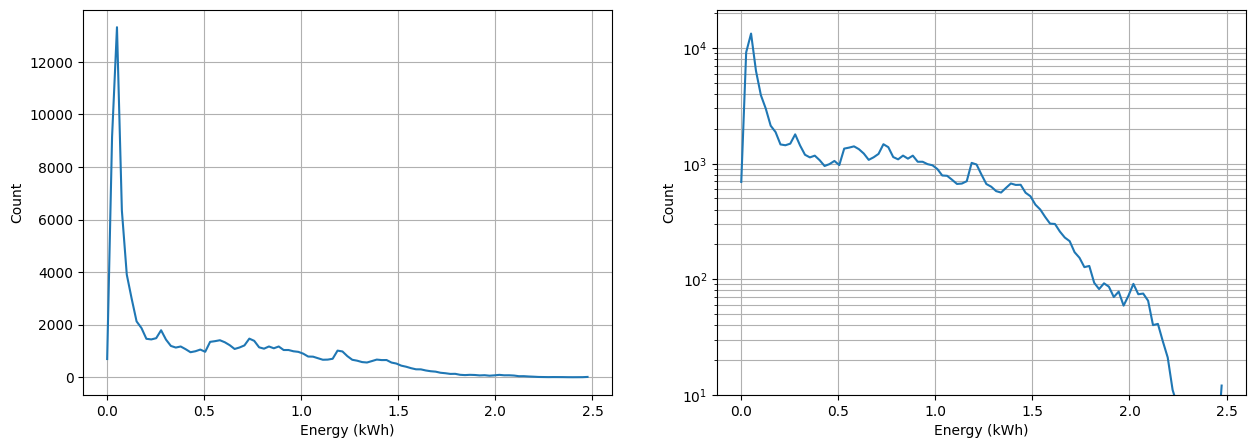

In [ ]:
# define the energy intervals to use for the histogram
bins = np.linspace(0, 2.5, 100)

# calculate the distribution of energy values
df_smd_hist, _=np.histogram(df_smd['Value'], bins=bins)

# define a figure with 2 columns
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# plot the histogram
ax[0].plot(bins[:-1], df_smd_hist)
ax[0].set_xlabel('Energy (kWh)')
ax[0].set_ylabel('Count')
ax[0].grid()

# plot the histogram on a logarithmic scale
ax[1].plot(bins[:-1], df_smd_hist)
ax[1].set_yscale('log')
ax[1].set_ylim(10, None)
ax[1].set_xlabel('Energy (kWh)')
ax[1].set_ylabel('Count')
ax[1].grid(which='both')

## Multi-dimensional visualizations
The simple line graphs can be advantageous for plotting average data or short periods of time (e.g., a few days). However, observing longer periods in this way is difficult due to the density of the measurements. In the case of smart meter data, we are particularly interested in observing the behavior of prominent appliances and their regular on/off switching per day. Heatmaps are a very powerful method to visualize the corresponding time series patterns in a multidimensional way.

To achieve this, we divide each timestamp into day and time, which can be interpreted as transferring time in one dimension into a two-dimensional space. Consequently, the axes of the heatmap are as follows:
- x-axis: shows the date in chronological order from left to right
- y-axis: shows the time of day in chronological order from top to bottom

Interpreting the area spanned by x and y as a canvas that you can color according to the patterns generated by the smart meter data:
- The position of each pixel in the canvas is indicated by the date and time (eg: the timestamp)
- The color of each pixel is defined by a mapping of the energy consumption at the given time to continuous color scale


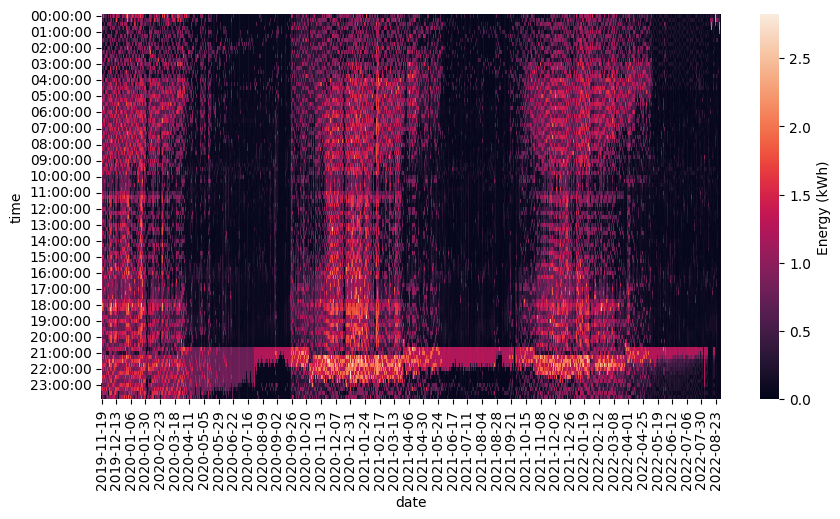

In [ ]:
import matplotlib.dates as mdates
from matplotlib.dates import AutoDateLocator, DateFormatter
# ------------------------
# DEFINE HELPER FUNCTION
# ------------------------

def create_heatmap(df, column, interval_minutes=15):
  # As we will add additional columns and do not want the original data to be affected, create copy of the original data frame
  data_df = df.copy()
  # Add columns for date and time
  data_df["date"] = data_df.index.date
  data_df["time"] = data_df.index.time
  # Define a function that handles duplicate values which can occur in local time due to daylight savings time
  # Using only the first datapoint instead of summing avoids unrealistically height demand
  get_first = lambda x: x.iloc[0]
  # Pivot dates and times to create a two dimensional representation
  data = data_df.pivot_table(index='time', columns='date', values=column, aggfunc=get_first, dropna=False)
  return data

# ------------------------
# CREATE THE FIGURE
# ------------------------

hm = create_heatmap(df_smd, column='Value')

fig_hm, ax_hm = plt.subplots(1, 1, figsize=(10, 5))
# Seaborn has a function to plot the dataframe including time labels for the axes
sns.heatmap(hm, ax=ax_hm, cbar_kws={'label': 'Energy (kWh)'})

fig.show()

## Combined smart meter data with weather data

In order to interpret data correctly, a link to the local weather is often required. For example, if a building is heated or cooled electrically, the energy consumption often depends strongly on the outside temperature. Similarly, the energy consumption of a building with a PV system is most likely affected by the hours of sunshine on each day. Smart meter data and weather data often come from different sources. Therefore, we will now show you how to merge weather and energy data into one data frame, which can facilitate any analysis.

- Remember that in a section in the beginning you have loaded not only the smart meter data, but also some temperature data in hourly and daily resolution
Remember that the df_weather_daily data frame contains only dates as indices (YYYY-MM-DD).
- The data frame df_weather_hourly contains dates and hours as indices (YYYY-MM-DD HH)
- The smart meter data df_smd contains dates and times as indices (YYYY-MM-DD HH:MM).

In [ ]:
# handle different types of timestamps
df_weather = pd.merge( df_weather_daily, df_weather_hourly, left_index=True, right_index=True, how='left')

def merge_smd_with_weather(df_smd, df_weather, hourly=False):
  '''
    Merges a weather data frame into the data frame containing the smart meter data.
    Can cope with daily and hourly weather.
    NOTE: assumes that parameters df_smd and df_weather have the timestamps as index and that they are of type pd.datetime
    Args:
      df_smd: the pandas data frame holding smart meter data
      df_smd: the pandas data frame holding weather data
      hourly: boolean to set to True if the weather data is in hourly resolution, otherwise assumming daily
    Returns:
      copy of the SMD data frame with the weather observations merged into it as additional columns
  '''
  # as we wil add additional columns and do not want the original data to be affected, create copies of the original data frames
  df_smd_copy = df_smd.copy()
  df_weather_copy = df_weather.copy()
  # Check if the index is already a MultiIndex
  if not isinstance(df_smd_copy.index, pd.MultiIndex):
    df_smd_copy.index = pd.MultiIndex.from_arrays(arrays = [df_smd_copy.index.date, df_smd_copy.index.hour], names=['date_temp', 'hour_temp'])
  else:
    # If it's a MultiIndex, access the levels
    df_smd_copy.index = pd.MultiIndex.from_arrays(arrays = [df_smd_copy.index.get_level_values(0), df_smd_copy.index.get_level_values(1)], names=['date_temp', 'hour_temp'])
  df_weather_copy.index=pd.MultiIndex.from_arrays(arrays = [df_weather_copy.index.date, df_weather_copy.index.hour], names=['date_temp', 'hour_temp'])
  # merge the weather data into the smart meter data
  if hourly:
    df_combined = df_smd_copy.merge(df_weather_copy, on=['date_temp', 'hour_temp'])
  else:
    df_combined = df_smd_copy.merge(df_weather_copy, on=['date_temp'])

  return df_combined

# ADDING TEMPERATURES TO SMD
# add daily temperatures
df_combined = merge_smd_with_weather(df_smd, df_weather_daily, hourly = True )
# add hourly temperatures
df_combined = merge_smd_with_weather(df_combined, df_weather_hourly, hourly=True)

display(df_combined)

Value  Value_HeatPump  Value_OtherAppliances  \
date_temp  hour_temp                                                 
2019-11-20 0          0.650           0.608                  0.042   
           0          0.637           0.541                  0.096   
           0          0.070           0.023                  0.047   
           0          0.615           0.558                  0.057   
2019-11-21 0          0.653           0.611                  0.042   
...                     ...             ...                    ...   
2022-08-30 0          0.035           0.003                  0.032   
2022-08-31 0          0.053           0.003                  0.050   
           0          0.056           0.003                  0.053   
           0          0.048           0.003                  0.045   
           0          0.045           0.003                  0.042   

                      daily_mintemp  daily_maxtemp  daily_avgtemp  \
date_temp  hour_temp                                                
2019-11-20 0                      2              7              4   
           0                      2              7              4   
           0                      2              7              4   
           0                      2              7              4   
2019-11-21 0                      0              7              4   
...                             ...            ...            ...   
2022-08-30 0                     16             20             19   
2022-08-31 0                     14             20             18   
           0                     14             20             18   
           0                     14             20             18   
           0                     14             20             18   

                      hourly_temperature  
date_temp  hour_temp                      
2019-11-20 0                           5  
           0                           5  
           0                           5  
           0                           5  
2019-11-21 0                           2  
...                                  ...  
2022-08-30 0                          18  
2022-08-31 0                          17  
           0                          17  
           0                          17  
           0                          17  

[4064 rows x 7 columns]

In [ ]:
df_combined.to_csv('loadconsumption&weather.csv', index=True)

Since the hourly and daily weather data have lower resolution than the smart meter data. Therefore, we now have duplicate entries for each hour in the hourly weather data and for each day in the daily weather data. However, we can use this information to calculate the correlation of energy and temperature measurements.

In [ ]:
# calculate correlation across all days
corr = stats.pearsonr(df_combined['Value'], df_combined['daily_avgtemp'])
print('Correlation across all days:', np.round(corr [0], 2))

Correlation across all days: -0.56


The energy consumption correlates negatively with the outside air temperature. Often, instead of using temperature directly, a value is calculated that indicates whether a day is a heating day and how cold that heating day is. This value should be zero for non-heating days and non-zero otherwise. The higher the value, the more heating is required on that day.

We calculate this value as follows and call its heating degree day (HD): HD = b x (tmr - tmo)

- tmr: is the assumed mean room temperture
- tmo: is the mean outdoor temperature of a day
- b: is a boolean variable which has the value 1 if the mean outdoor
- temperature of a day is below the heating limit and the value 0 otherwise.

Correlation of energy with heating degree day: 0.56


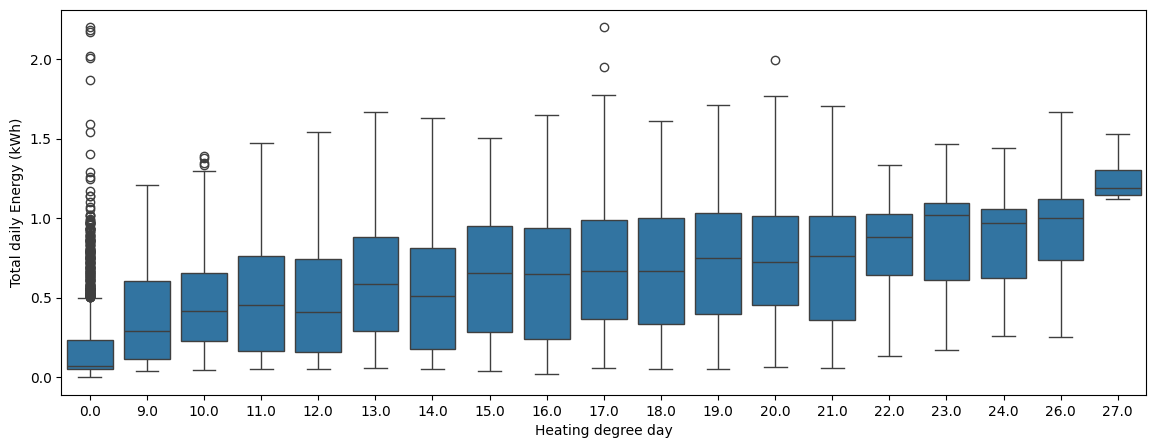

heating_degree  median      mean       std  count
0              0.0  0.0700  0.190636  0.250039   1828
1              9.0  0.2905  0.389295  0.310608    156
2             10.0  0.4165  0.464354  0.334770    164
3             11.0  0.4515  0.498403  0.347454    176
4             12.0  0.4085  0.487880  0.356349    208
5             13.0  0.5870  0.608780  0.383516    168
6             14.0  0.5110  0.548912  0.389889    148
7             15.0  0.6560  0.637825  0.382712    200
8             16.0  0.6480  0.622462  0.405949    156
9             17.0  0.6685  0.701129  0.436036    240
10            18.0  0.6670  0.685889  0.397312    208
11            19.0  0.7475  0.737056  0.418396    180
12            20.0  0.7250  0.720643  0.396673    112
13            21.0  0.7615  0.727000  0.424418     60
14            22.0  0.8805  0.784750  0.361992     16
15            23.0  1.0215  0.874312  0.366662     16
16            24.0  0.9675  0.881167  0.328451     12
17            26.0  1.0030  0.932917  0.365746     12
18            27.0  1.1920  1.258750  0.187101      4

In [ ]:
def calculate_heating_degree_day(df, temp_column='daily_avgtemp', room_temp=20.0, heating_limit_temp=12.0):
  '''
    Calculates heating degree day values and adds them as additional column to the data frame.
    Args:
      df_weather: data frame (must contain temperature readings)
      temp_column: string defining the column name of the average temperature value per day
      room_temp: assumed room temperature (in Switzerland, usually 20 degrees Celsius)
      heating_limit_temp: heating limite temperature (in Switzerland, usually 12 degrees Celsius)
    Returns:
      data given data frame with an additional column
  '''
  df = df.copy()
  df['heating_degree'] = np.where(df[temp_column] < heating_limit_temp, room_temp - df[temp_column], 0)
  df.loc[df[temp_column].isnull(), 'heating_degree'] = np.nan
  return df

# APPLY CALCULATIONS
# calculate the degree day for each observation
df_hd = calculate_heating_degree_day(df_combined, temp_column='daily_avgtemp', room_temp = 20, heating_limit_temp=12)
# calculate correlation of energy with heating degree
corr = stats.pearsonr(df_hd['Value'], df_hd['heating_degree'])
print('Correlation of energy with heating degree day:', np.round(corr[0], 2))

# plot box plots that group the observations over degree days
fig, ax = plt.subplots(figsize=(14,5))
sns.boxplot(x='heating_degree', y='Value', data=df_hd, ax=ax)
ax.set_xlabel('Heating degree day')
ax.set_ylabel('Total daily Energy (kWh)')
plt.show()

#group the observations by degree day and calculate statistics for each degree day
df_median = df_hd.groupby('heating_degree').median().reset_index()[['heating_degree', 'Value']].rename(columns={'Value':'median'})
df_mean = df_hd.groupby('heating_degree').mean().reset_index()[['heating_degree', 'Value']].rename(columns={'Value':'mean'})
df_std = df_hd.groupby('heating_degree').std().reset_index()[['heating_degree', 'Value']].rename(columns={'Value':'std'})
df_count = df_hd.groupby('heating_degree').count().reset_index()[['heating_degree', 'Value']].rename(columns={'Value':'count'})

# combine all statistics
df_grouped = pd.merge(df_median, df_mean, on='heating_degree', how='left')
df_grouped = pd.merge(df_grouped, df_std, on='heating_degree', how='left')
df_grouped = pd.merge(df_grouped, df_count, on='heating_degree', how='left')
df_grouped

## Add additional information for filtering timestamps
In some cases, it may be beneficial to add additional columns to the data frame describing the time of day or seasons, etc, as this allows for improved filtering or grouping of the time series. We can add these columns by simply indexing the data frame.

In [ ]:
# --------------------------------
# DEFINE HELPER FUNCTION
# --------------------------------

def add_descriptive_columns(df, basic=True, seasons=True, weekday=True, daytime=True):
  '''
      Creates a copy of the SMD data frame and adds additional descriptive columns.
      NOTE: assumes that the timestamp is set as index of the data frame and is of type pd.datetime
      Args:
          df: data frame holding the smart meter data
          basic: boolean to set to True if very basic information should be added
          seasons: boolean to set to True if the seasons should be added
          weekday: boolean to set to True if distinction between weekend and weekday should be added
          daytime: boolean to set to True if the time of day should be added (e.g. morning vs evening)
      Returns:
          processed copy of the data frame with additional columns
  '''

  # create a copy of the data frame as we do not want the original data to be affected
  df = df.copy()

  # add some basic columns
  df['date'] = df.index.date
  df['time_utc'] = df.index.tz_convert('UTC').time
  df['year'] = df.index.year
  df['month'] = df.index.month
  df['week'] = df.index.isocalendar().week
  df['dayOfWeek'] = df.index.dayofweek
  df['hour_utc'] = df.index.tz_convert('UTC').hour
  df['minute'] = df.index.minute

  # mapping months to seasons: 1- winter, 2-spring, 3-summer, 4-autumn
  if seasons:
    seasons = {1: 1, 2: 1, 3: 2, 4: 2, 5:2, 6:3, 7:3, 8:3, 9:4, 10:4, 11:4, 12:1} # maps months to seasons:
    df['season'] = df['month'].map(seasons, na_action=None)
    df['winter'] = np.where(df['season'] == 1, True, False)
    df['spring'] = np.where(df['season'] == 2, True, False)
    df['summer'] = np.where(df['season'] == 3, True, False)
    df['autumn'] = np.where(df['season'] == 4, True, False)
    df['transitionperiod'] = np.where((df['season'] == 2) | (df['season'] == 4), True, False)

  # mapping to descriptive times of the day
  if weekday:
    df['weekday'] = np.where(df['dayOfWeek'] <=4, True, False)
    df['weekend'] = np.where(df['dayOfWeek'] >=5, True, False)

  # add the time of day
  if daytime:
    df['morning'] = np.where(df['hour_utc'].between(6, 10, inclusive='left'), True, False)
    df['noon'] = np.where(df['hour_utc'].between(10, 14, inclusive='left'), True, False)
    df['afternoon'] = np.where(df['hour_utc'].between(14, 18, inclusive='left'), True, False)
    df['evening'] = np.where(df['hour_utc'].between(18, 23, inclusive='left'), True, False)
    df['day'] = np.where(df['hour_utc'].between(6, 23, inclusive='left'), True, False)
    df['night'] = np.where((df['hour_utc'] >= 23) | (df['hour_utc'] < 6), True, False)

  if not basic:
    df.drop(columns=['date', 'time_utc', 'year', 'month', 'week', 'dayOfWeek', 'hour_utc', 'minute'], inplace=True)
  return df

# --------------------------------
# APPLY HELPER FUNCTION
# --------------------------------

# let's add some information about the seasons
df_add = add_descriptive_columns(df_smd, basic=False, seasons=True, weekday=False, daytime=True)
display(df_add)

# now let's for example compare the mean consumption of summer vs. winter
print('Mean energy consumption in summer per 15 min:', np.round(df_add[df_add['summer']]['Value'].mean(), 3))
print('Mean energy consumption in winter per 15 min:', np.round(df_add[df_add['winter']]['Value'].mean(), 3))

Value  Value_HeatPump  Value_OtherAppliances  \
Timestamp                                                                 
2019-11-19 23:00:00+00:00  0.736           0.682                  0.054   
2019-11-19 23:15:00+00:00  1.216           1.126                  0.090   
2019-11-19 23:30:00+00:00  0.488           0.450                  0.038   
2019-11-19 23:45:00+00:00  0.065           0.023                  0.042   
2019-11-20 00:00:00+00:00  0.650           0.608                  0.042   
...                          ...             ...                    ...   
2022-08-31 20:45:00+00:00  0.052           0.000                  0.052   
2022-08-31 21:00:00+00:00  0.035           0.000                  0.035   
2022-08-31 21:15:00+00:00  0.031           0.000                  0.031   
2022-08-31 21:30:00+00:00  0.042           0.000                  0.042   
2022-08-31 21:45:00+00:00  0.043           0.000                  0.043   

                           season  winter  spring  summer  autumn  \
Timestamp                                                           
2019-11-19 23:00:00+00:00       4   False   False   False    True   
2019-11-19 23:15:00+00:00       4   False   False   False    True   
2019-11-19 23:30:00+00:00       4   False   False   False    True   
2019-11-19 23:45:00+00:00       4   False   False   False    True   
2019-11-20 00:00:00+00:00       4   False   False   False    True   
...                           ...     ...     ...     ...     ...   
2022-08-31 20:45:00+00:00       3   False   False    True   False   
2022-08-31 21:00:00+00:00       3   False   False    True   False   
2022-08-31 21:15:00+00:00       3   False   False    True   False   
2022-08-31 21:30:00+00:00       3   False   False    True   False   
2022-08-31 21:45:00+00:00       3   False   False    True   False   

                           transitionperiod  morning   noon  afternoon  \
Timestamp                                                                
2019-11-19 23:00:00+00:00              True    False  False      False   
2019-11-19 23:15:00+00:00              True    False  False      False   
2019-11-19 23:30:00+00:00              True    False  False      False   
2019-11-19 23:45:00+00:00              True    False  False      False   
2019-11-20 00:00:00+00:00              True    False  False      False   
...                                     ...      ...    ...        ...   
2022-08-31 20:45:00+00:00             False    False  False      False   
2022-08-31 21:00:00+00:00             False    False  False      False   
2022-08-31 21:15:00+00:00             False    False  False      False   
2022-08-31 21:30:00+00:00             False    False  False      False   
2022-08-31 21:45:00+00:00             False    False  False      False   

                           evening    day  night  
Timestamp                                         
2019-11-19 23:00:00+00:00    False  False   True  
2019-11-19 23:15:00+00:00    False  False   True  
2019-11-19 23:30:00+00:00    False  False   True  
2019-11-19 23:45:00+00:00    False  False   True  
2019-11-20 00:00:00+00:00    False  False   True  
...                            ...    ...    ...  
2022-08-31 20:45:00+00:00     True   True  False  
2022-08-31 21:00:00+00:00     True   True  False  
2022-08-31 21:15:00+00:00     True   True  False  
2022-08-31 21:30:00+00:00     True   True  False  
2022-08-31 21:45:00+00:00     True   True  False  

[97532 rows x 15 columns]

Mean energy consumption in summer per 15 min: 0.164
Mean energy consumption in winter per 15 min: 0.912


## Normalisation Method
Since I want to compare energy consumption across different seasons, I'm going to normalize by weather metrics.

Value  Value_HeatPump  Value_OtherAppliances  \
Timestamp                                                                 
2019-11-19 23:00:00+00:00  0.736           0.682                  0.054   
2019-11-19 23:15:00+00:00  1.216           1.126                  0.090   
2019-11-19 23:30:00+00:00  0.488           0.450                  0.038   
2019-11-19 23:45:00+00:00  0.065           0.023                  0.042   
2019-11-20 00:00:00+00:00  0.650           0.608                  0.042   
...                          ...             ...                    ...   
2022-08-31 20:45:00+00:00  0.052           0.000                  0.052   
2022-08-31 21:00:00+00:00  0.035           0.000                  0.035   
2022-08-31 21:15:00+00:00  0.031           0.000                  0.031   
2022-08-31 21:30:00+00:00  0.042           0.000                  0.042   
2022-08-31 21:45:00+00:00  0.043           0.000                  0.043   

                           Value_Scaled  
Timestamp                                
2019-11-19 23:00:00+00:00      0.424269  
2019-11-19 23:15:00+00:00      1.385039  
2019-11-19 23:30:00+00:00     -0.072129  
2019-11-19 23:45:00+00:00     -0.918809  
2019-11-20 00:00:00+00:00      0.252131  
...                                 ...  
2022-08-31 20:45:00+00:00     -0.944829  
2022-08-31 21:00:00+00:00     -0.978857  
2022-08-31 21:15:00+00:00     -0.986863  
2022-08-31 21:30:00+00:00     -0.964846  
2022-08-31 21:45:00+00:00     -0.962844  

[97532 rows x 4 columns]

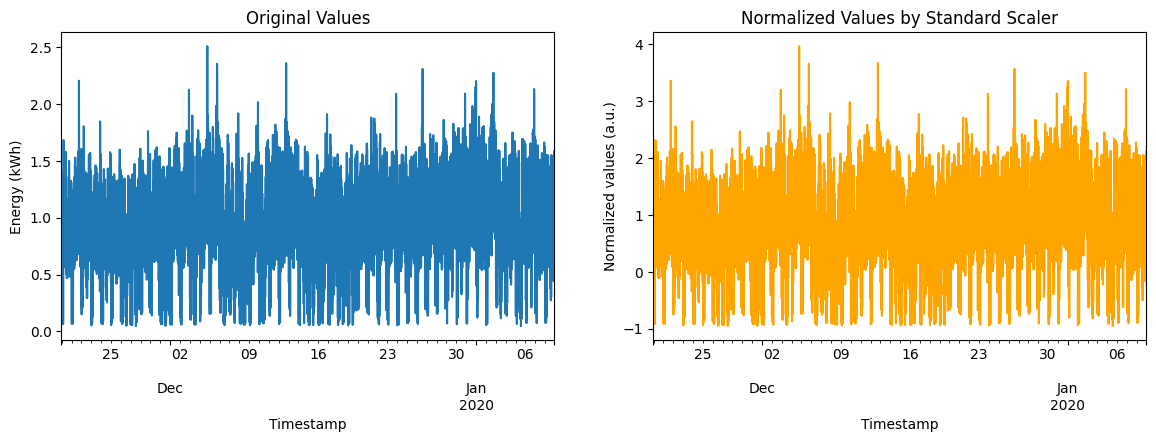

In [ ]:
# ---------------------
# APPLY STANDARD SCALER
# ---------------------

# copy data to not affect original data
df_norm = df_smd.copy()

# apply standard scaler
np_vals = df_smd['Value'].values.reshape(-1, 1)
scaler = StandardScaler().fit(np_vals)
np_vals = scaler.transform(np_vals)

# assign normalized values to new column
df_norm['Value_Scaled'] = np_vals.flatten()
display(df_norm)


# ---------------------
# VISUALIZE RESULT
# ---------------------

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
days = 50
df_norm.iloc[:96*days]['Value'].plot(ax=ax[0])
df_norm.iloc[:96*days]['Value_Scaled'].plot(ax= ax[1], color='orange')
ax[0].set_title('Original Values')
ax[0].set_ylabel('Energy (kWh)')
ax[1].set_title('Normalized Values by Standard Scaler')
ax[1].set_ylabel('Normalized values (a.u.)')
plt.show()

In [ ]:
df_norm.to_csv('df_norm.csv', index=True)

## Interpolation methods and downsampling
As I want to analyse energy consumption by year, hour or day, for example, I need to convert the data to a lower temporal solution. Basically, I'm going to sum up the consumption over several timestamps. In pandas this can be done in a comparatively simple way by resampling the data.

In [ ]:
# define the pandas keys for the most common resolution changes
resolution_dict = {
    'daily': '1D',
    '30min' : '30min',
    'hourly' : '1H',
    'monthly' : '1M',
    'yearly' : '1Y'
}

# choose your resolution and resample
resolution = 'daily'
df_resampled = df_smd.resample(resolution_dict[resolution]).sum()
display(df_resampled)

Value  Value_HeatPump  Value_OtherAppliances
Timestamp                                                               
2019-11-19 00:00:00+00:00   2.505           2.281                  0.224
2019-11-20 00:00:00+00:00  83.930          41.531                 42.399
2019-11-21 00:00:00+00:00  89.858          40.390                 49.468
2019-11-22 00:00:00+00:00  84.108          41.844                 42.264
2019-11-23 00:00:00+00:00  83.460          42.359                 41.101
...                           ...             ...                    ...
2022-08-27 00:00:00+00:00   5.284           1.762                  3.522
2022-08-28 00:00:00+00:00   4.561           1.045                  3.516
2022-08-29 00:00:00+00:00  10.551           6.969                  3.582
2022-08-30 00:00:00+00:00   3.757           0.259                  3.498
2022-08-31 00:00:00+00:00   3.334           0.116                  3.218

[1017 rows x 3 columns]

In [ ]:
df_resampled.to_csv('resampleddata.csv', index=True)

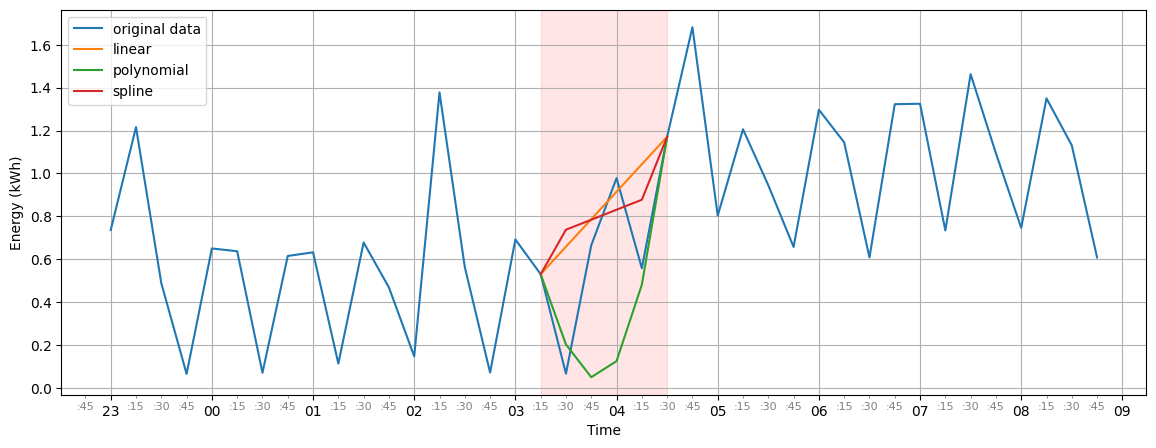

In [ ]:
# take a segment of data points
start = 0
stop = 40
start_missing = 18
stop_missing = 22
excerpt = df_smd.iloc[start:stop].copy()

# remove data for 4 consecutive data points
missing = excerpt.copy()
missing.iloc[start_missing:stop_missing, missing.columns.get_loc('Value')] = np.nan


# create figure
fig, ax = plt.subplots(figsize=(14, 5))

# plot different interpolations
ax.plot(excerpt['Value'], label='original data')
ax.plot(missing['Value'].interpolate().iloc[start_missing - 1:stop_missing + 1], label='linear')
ax.plot(missing['Value'].interpolate(method='polynomial', order=3).iloc[start_missing - 1:stop_missing + 1], label='polynomial')
ax.plot(missing['Value'].interpolate(method='spline', order=3).iloc[start_missing - 1:stop_missing + 1], label='spline')
ax.axvspan(excerpt.index[start_missing - 1], excerpt.index[stop_missing], color='red', alpha=0.1)

# additional formatting and show plot
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(range(15, 60, 15)))
ax.xaxis.set_minor_formatter(mdates.DateFormatter(":%M"))
ax.tick_params(axis='x', which='minor', labelsize=8, colors='grey')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Energy (kWh)')
ax.legend()
fig.show()

The interpolated data does not quite match the original data points. The higher order polynomials in particular lead to large fluctuations in the interpolation. Nonetheless, interpolation can help deal with missing data, especially when only short gaps of a single missing measurement are involved. As a more systematic test, we randomly remove 5% of the data and apply different interpolation techniques. We can see the strength of the interpolation. The mean absolute error between the interpolated and original data is consistently lower than when we naively fill in missing data with zero.


In [ ]:
# remove 5% of the data
indices = np.random.choice(len(df_smd.index), size=int(0.05 * len(df_smd.index)), replace=False)
masked_df = df_smd['Value'].copy()
masked_df.iloc[indices] = np.nan

# define the parameters for the different interpolations
parameters = [
    {'method': 'linear', 'order': None},
    {'method': 'polynomial', 'order': 3},
    {'method': 'polynomial', 'order': 5},
    {'method': 'spline', 'order': 3},
]

# calculate the mean absolute error of each interpolation
print('Mean absolute error: \n')
for d in parameters:
  print(d['method'] + ':', np.round(mean_absolute_error(masked_df.interpolate(**d), df_smd['Value']), 4))

# for comparison simply fill with zero
print('fill zeros:', np.round(mean_absolute_error(masked_df.fillna(0), df_smd['Value']), 4))

Mean absolute error: 

linear: 0.0111
polynomial: 0.0106
polynomial: 0.011
spline: 0.0196
fill zeros: 0.0261


## Outlier detection with Hampel filter
Outlier detection methods are suitable for detecting unrealistic measurements. Hampel filtering is such a method to detect outliers based on a sliding window approach in which data points are compared to the distribution of their neighbors. The method has two parameters:
- window size controls the size of the neighborhood to be considered for the distribution
- n_sigmas determines how far out of the distribution a point must fall, to be considered an outlier

Together, the parameters can be used to set the aggressiveness of the filtering. When a data point is detected as an outlier, its value is replaced by the median of its neighbors' distribution.

Share of outliers in the series: 0.005555555555555556


<ipython-input-19-c68c597baea0>:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [filtered[mask][0], excerpt[mask][0]], ls='--', c='r')


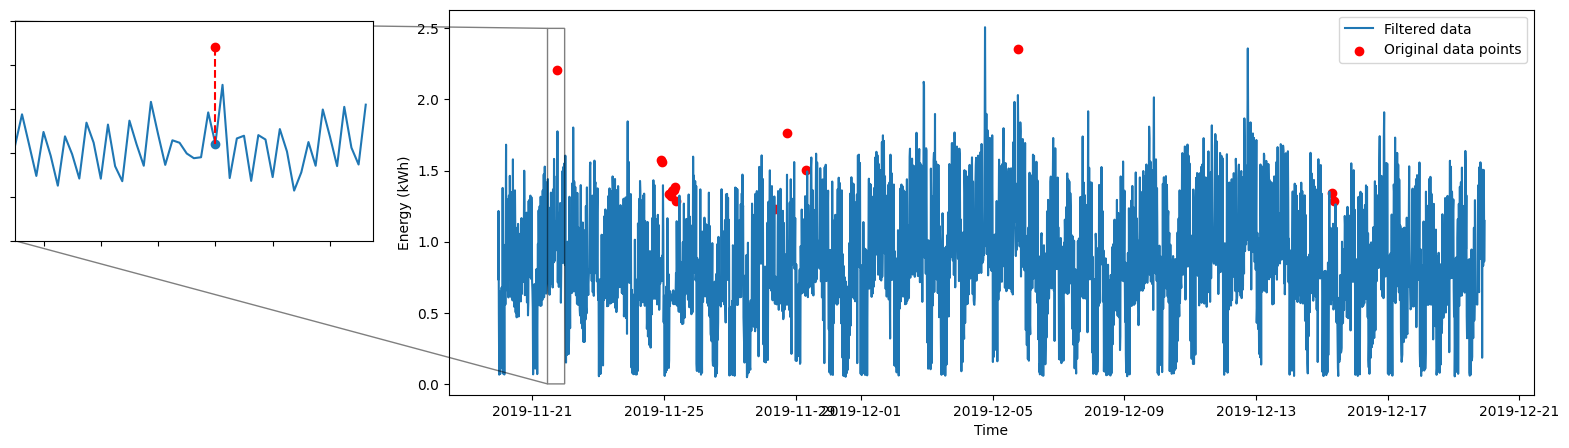

In [ ]:
# ------------------------
# DEFINE HELPER FUNCTION
# ------------------------

def hampel_filter(series, window_size, n_sigmas=3):
  '''
  Implementation based on https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d
  '''
  k = 1.4826  # scale factor for Gaussian distribution

  # make a new series in which we overwrite the outliers
  new_series = series.copy()

  # calculate the median of the data in the neighborhood
  rolling_median = series.rolling(window=2 * window_size, center=True).median()

  # calculate the median absolute difference to estimate the spread of the distribution
  rolling_mad = k * series.rolling(window=2 * window_size, center=True).apply(
      lambda x: np.median(np.abs(x - np.median(x)))
  )

  # calculate the deviation of each point from the median
  diff = np.abs(series - rolling_median)

  # select values that deviate more than n_sigma from the mad and replace them with the median
  mask = diff > (n_sigmas * rolling_mad)
  new_series[mask] = rolling_median[mask]

  print('Share of outliers in the series:', mask.mean())

  return new_series, mask

# -----------------
# APPLY FILTERING
# -----------------

# apply filter to one month of data
excerpt = df_smd['Value'].iloc[:96 * 30]
filtered, mask = hampel_filter(excerpt, 15)


fig, ax = plt.subplots(figsize=(14, 5))
# plot the filtered time series
ax.plot(filtered, label='Filtered data')
# plot dots for the filtered out data
ax.scatter(excerpt.index[mask], excerpt[mask], c='r', label='Original data points')
ax.set_xlabel('Time')
ax.set_ylabel('Energy (kWh)')
ax.legend()

# Magnify a section of the data
start = int(1.5 * 96)
stop = start + 50
axins = ax.inset_axes([-0.4, 0.4, 0.33, 0.57])
# plot the filtered data
axins.plot(filtered.index[start:stop], filtered[start:stop])
axins.scatter(excerpt.index[mask], filtered[mask])
# plot the original data
axins.scatter(excerpt.index[mask], excerpt[mask], c='r')
axins.plot([excerpt.index[mask][0], excerpt.index[mask][0]],
           [filtered[mask][0], excerpt[mask][0]], ls='--', c='r')

axins.set_xlim(excerpt.index[start], excerpt.index[stop])
axins.set_ylim(0, 2.5)
axins.set_xticklabels([])
axins.set_yticklabels([])
ax.indicate_inset_zoom(axins, edgecolor="black")

fig.show()

## Simple baseload estimation
The term baseload refers to the minimum amount of electricity that a householf or building uses on a fairly continuous basis. It is independent of whether or not someone is actively using appliances or electronics. For example, it can be caused by heating and cooling systems, refrigerators, or other major appliances that run continously even when no one is home. Normally, the baseload can be beneficial for energy conservation initiatives or for identifying unusual spike to detect device failures, leaks or other issues that may need attention.
In the following, we estimate the baseload of the given smart meter data using a sample distribution-based approach with the following steps:
- First, we sort all energy observations in asecending order.
- then, we decide on a certain percentage (20% by default) of the smallest values to be considered for the calculation.
- then we calculate the mean and standard deviation of the values to be considered
- finally, we define the baseload as the first value above the mean plus three times the calculated standard deviation.

Estimated baseload: 0.084


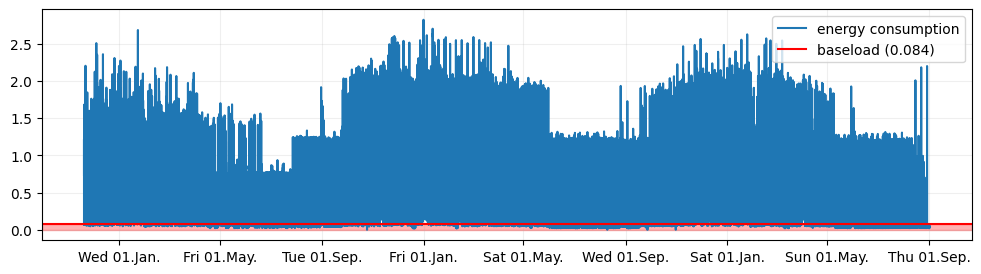

In [ ]:
# ------------------------
# DEFINE HELPER FUNCTION
# ------------------------

def estimate_baseload(df, val_share_included=0.2):
  '''
      Estimates the standby-/baseload of a data frame Oh I know, but window bandit push, you could chuck wellcontaining smart meter data.
      Baseload is assumed to be the first kWh-value of whole df that is > mean+3*std of ascendingly sorted kWh values to be considered (as given by val_share_included)
      Args:
          val_share_included: percentage of ascendingly sorted kWh-values to be considered for calculating mean and std
      Returns:
          float representing the calculated baseload
  '''

  # NOTE: current approach is rather naive and suitable for aggregated smart meters

  # copy the data frame and sort it ascendingly
  df_sorted = df.copy().sort_values(by='Value', ascending=True)

  # decide for the cut-off of values to be considered
  stop_index = math.ceil(val_share_included * len(df))

  # calculate mean and standard deviation
  mean = df_sorted[:stop_index]['Value'].mean()
  std = df_sorted[:stop_index]['Value'].std()

  # estimate the baseload and return it as rounded value
  baseload = df_sorted[df_sorted['Value'] > mean+3*std]['Value'].iloc[0]
  return round(baseload, 4)

# ------------------------
# APPLY BASELOAD ESTIMATION
# ------------------------

# estimate the baseload
baseload = estimate_baseload(df_smd, val_share_included=0.2)
print('Estimated baseload:', baseload)

# ------------------------------------
# PLOT ENERGY CONSUMPTION AND BASELOAD
# ------------------------------------

# let's see what this looks like in a plot
fig, ax = plt.subplots(figsize=(12,3))
df_sub = add_descriptive_columns(df_smd, seasons=True)
days = 7
df_sub = df_sub[df_sub['winter']].iloc[:96*days]
ax.plot(df_smd['Value'], label='energy consumption')
ax.axhline(y=baseload, color='red', label='baseload ({})'.format(baseload))
ax.axhspan(ymin=0, ymax=baseload, color='red', alpha=0.3)
ax.legend()
ax.grid(alpha=0.2)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%a %d.%b."))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

## Enhancing small activities
We can use the baseload calculated above as a threshold to filter out all measured values that are smaller. For example, devices such as LED light bulbs, laptops, smartphones or tablets tend to consume little power compared to other large loads such as heat pumps. Alternatively, we can enhance small activities by apply transformation function to the energy values. The function should compress large values and and expand small numbers relatively. This may result in less skewed values (especially for distributions with long tail ends), but requries an additional step to interpret the transformed energy measurements (since the inverse transform should be applied before interpretation)
The square root transformation works particularly well for energy data.

Review the activities caused by the heat pump controller with comparatively low power consumption are now enhanced.

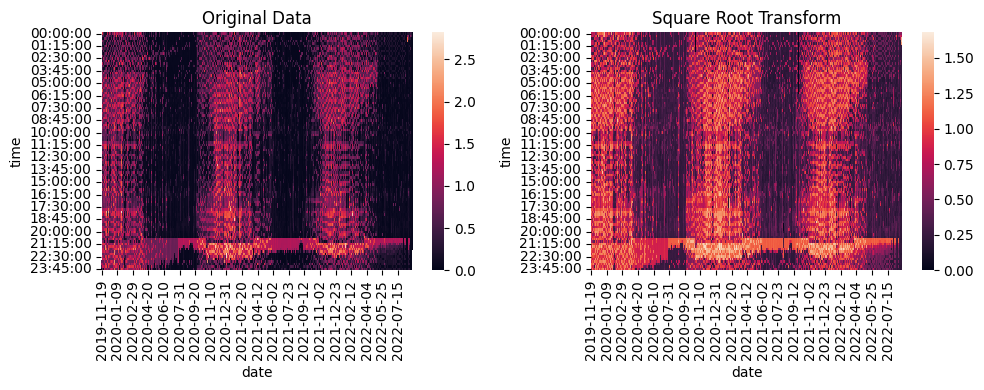

In [ ]:
#----------------------
# APPLY TRANSFORMATION
#----------------------

# apply square root transformation
df_sqrt = np.sqrt(df_smd)

#--------------------------------
# CREATE HEATMAPS FOR COMPARISON
#--------------------------------
# NOTE: we use the heatmap function introduced earlier

# create figure
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# first plot
sns.heatmap(create_heatmap(df_smd, column='Value'), ax=ax[0])
ax[0].set_title('Original Data')

# second plot
sns.heatmap(create_heatmap(df_sqrt, column='Value'), ax=ax[1])
ax[1].set_title('Square Root Transform')

plt.tight_layout()
plt.show()

## Detecting switching activities

Using the square-root transformed data to identify the switching events caused by the heatpump. A simple algorithm for finding switching events proceeds as follows:
- For each time t the difference of the consumption to t-2 is calculated - let us call the resulting values second differences
- A positive value of the second difference can now be interpreted as a switch-on event that must have occured between the last two measurements and a negative value refers to a switch-off event. A value close to zero indicates an insignificant change in consumption; eg: measurement errors, which we may wish to neglect.
- Applying a peak detection to the second difference allows to distinguish between prominent and non-prominent switching operations.

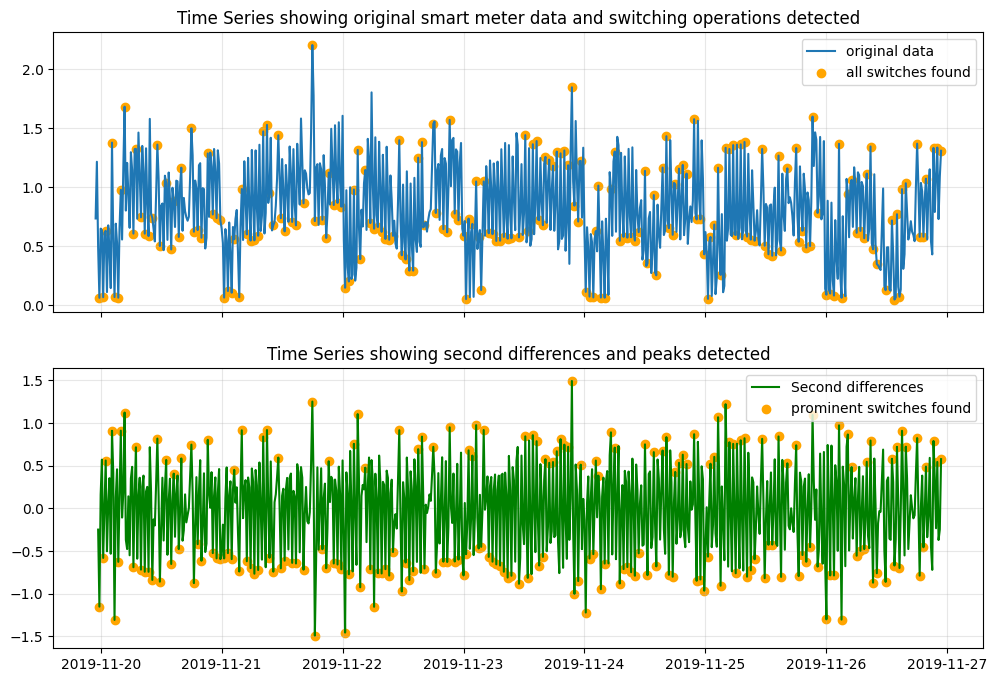

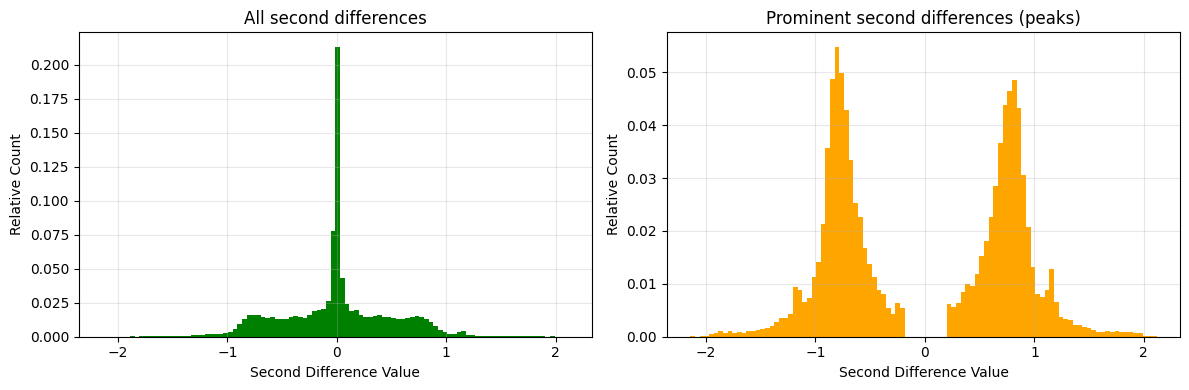

In [ ]:
#------------------------
# DEFINE HELPER FUNCTIONS
#------------------------

def calculate_second_differences(df, column='Value'):
  '''
      Calculates the difference of consumption of measurement t0 to t-2 and assigns it to time point t0.
      Adds these as separate column to the data frame - column named second_diff
      Args:
          df: data frame to be analyzed containing smart meter data
      Returns:
          returns copy of df where a new column named "second_diff" is available
              NOTE: first two values are NAN, because for these the previous measurements to not exist
  '''
  # copy data frame as original data should not be affected
  df = df.copy()
  # get consumption as vector
  np_cons = df[column].values
  # shift the consumption by two indices
  np_cons_shifted = np.roll(np_cons, 2)
  # subtract the shifted vector from the original one
  np_diff = np_cons - np_cons_shifted
  # replace the first two elements by NAN because there were actually no measurements to be subtracted
  np_diff[:2] = np.nan
  # add the differences again to the data frame
  df['second_diff'] = np_diff

  return df

def calculate_peaks_on_second_differences(df, prominence=None):
    '''
        Calculates the peaks on the second differences and adds a boolean indication as separate column called second_diff_peak.
        NOTE: it uses the absolute values of the differences to calculate peaks because the peak detection would ignore local minima.
        Args:
            df: data frame holding the calculated second difference values (assumed to be in column named second_diff)
            prominence: prominence parameter as defined in scipy.signal.find_peaks
        Returns:
            copy of df with additional column "second_diff_peak"
    '''

    # copy data frame as original data should not be affected
    df = df.copy()
    # get the local extrema on the absolute differences by peak detection
    np_peaks_indices = find_peaks(np.abs(df['second_diff'].values), prominence=prominence)[0]
    # mark in original data frame if the value is a peak or not
    df['second_diff_peak'] = False
    df.loc[df.iloc[np_peaks_indices].index, 'second_diff_peak'] = True
    return df

#------------------------
# APPLY SWITCHING DETECTION
#------------------------

# apply the second differences calculation
df_diff = calculate_second_differences(df_smd)

# apply peak detection to second differences
df_diff = calculate_peaks_on_second_differences(df_diff, prominence=0.2)

#-------------------------------------------
# PLOT TIMESERIES WITH IDENTIFIED SWITCHINGS
#-------------------------------------------

# create figure
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# select indices and values of found peaks
days = 7
df_sub = df_diff.iloc[:96*days]
indices = df_sub[df_sub['second_diff_peak']].index
peak_vals = df_sub.loc[indices, 'Value'].values
diff_vals = df_sub.loc[indices, 'second_diff'].values

# first plot: original time series
ax[0].plot(df_sub['Value'], label='original data')
ax[0].scatter(indices, peak_vals, color='orange', label='all switches found') # mark the found peaks
ax[0].legend()
ax[0].grid(alpha=0.3)
ax[0].set_title('Time Series showing original smart meter data and switching operations detected')

# second plot: second differences
ax[1].plot(df_sub['second_diff'], label='Second differences', color='green')
ax[1].scatter(indices, diff_vals, color='orange', label='prominent switches found') # mark the found peaks
ax[1].legend()
ax[1].grid(alpha=0.3)
ax[1].set_title('Time Series showing second differences and peaks detected')

plt.show()

#------------------------
# PLOT DISTRIBUTIONS
#------------------------

# create figure
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# plot the distributions of all second differences
np_diff = df_diff['second_diff'].values
weights = np.ones(len(np_diff)) / len(np_diff)
ax[0].hist(np_diff, bins=100, weights=weights, color='green')
ax[0].set_xlabel('Second Difference Value')
ax[0].set_ylabel('Relative Count')
ax[0].grid(alpha=0.3)
ax[0].set_title('All second differences')

# plot the distributions of only of the peak second differences
np_diff = df_diff[df_diff['second_diff_peak']]['second_diff'].values
weights = np.ones(len(np_diff)) / len(np_diff)
ax[1].hist(np_diff, bins=100, weights=weights, color='orange')
ax[1].set_xlabel('Second Difference Value')
ax[1].set_ylabel('Relative Count')
ax[1].grid(alpha=0.3)
ax[1].set_title('Prominent second differences (peaks)')

plt.tight_layout()
plt.show()

## Sliding window approaches
Without going into depth here, a common approach for working with time series data is to use a sliding window. A window is assigned a width and then slid over the time series with a fixed step size. In each window, an operation can be performed.
An easy way to apply a sliding window to smart meter data is to use the pandas internal rolling function. Pandas also provides a window operations guide online:

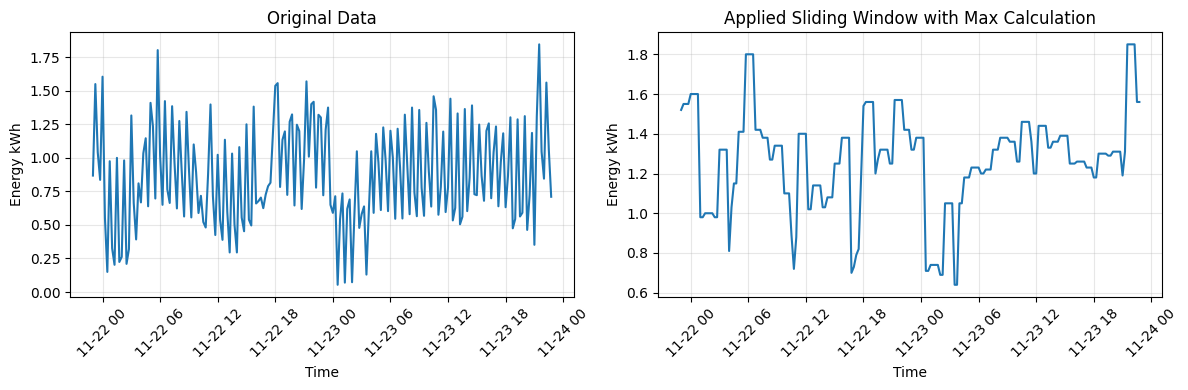

In [ ]:
# Select a window size
window_size = 4

# apply a sliding window with maximum calculation
df_sliding = df_smd.rolling(window_size).max().round(2)

# create figure to show the time series before and after sliding window
fig,ax = plt.subplots(1, 2, figsize=(12, 4))

# plot original data
plot_data(ax[0], df_smd.iloc[192:384])
ax[0].set_title('Original Data')
ax[0].grid(alpha=0.3)

# plot sliding window data
plot_data(ax[1], df_sliding.iloc[192:384])
ax[1].set_title('Applied Sliding Window with Max Calculation')
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
df_sliding.to_csv('slidingwindow.csv', index=True)

## Feature extraction
Many machine learning algorithms are not designed to deal with time series as input. Instead, features can extracted that describe the time series and can serve as input to the algorithms. This usually also has the advantage of dimensionality reduction. For example, clustering or classification algorithms such as K-nearest neighbor or random forest do not work well with the original time series, but with previously extracted features. In general, choosing the appropriate features depends on your use case and often requires expertise. The best question to ask yourself is: what do I want to achieve and hows does on household's data differ from another? It is easy to use and is designed for extracting features from arbitrary time series.


In [ ]:
import tsfresh
# copy the smart meter data to not affect the original data
df_copy = df_smd.copy()

# make sure that the data frame is sorted
df_copy.sort_index(inplace=True)

# NOTE: tsfresh requires an ID-column to know which time series refers to which ID
# hence could also combine the features extraction for data of multiple smart meters
# add the date as separate column and use it as ID to extract daily features
df_copy['date'] = df_copy.index.date

# =select ten random days for faster computing
dates = df_copy['date'].unique()
dates = np.random.choice(dates, size=10)
df_copy = df_copy[df_copy['date'].isin(dates)]

# extract all available features
df_features = tsfresh.extract_features(df_copy, column_id='date', show_warnings=False, disable_progressbar=True)
print('Number of extracted features:', len(df_features.columns.values))

# show the feature data frame
display(df_features)

Number of extracted features: 2364


Value__variance_larger_than_standard_deviation  \
2020-03-08                                             0.0   
2020-06-20                                             0.0   
2020-09-12                                             0.0   
2020-10-30                                             0.0   
2020-11-06                                             0.0   
2021-08-25                                             0.0   
2021-11-24                                             0.0   
2022-01-05                                             0.0   
2022-02-08                                             0.0   
2022-03-17                                             0.0   

            Value__has_duplicate_max  Value__has_duplicate_min  \
2020-03-08                       0.0                       0.0   
2020-06-20                       0.0                       0.0   
2020-09-12                       0.0                       0.0   
2020-10-30                       0.0                       0.0   
2020-11-06                       0.0                       0.0   
2021-08-25                       0.0                       1.0   
2021-11-24                       0.0                       1.0   
2022-01-05                       0.0                       0.0   
2022-02-08                       0.0                       1.0   
2022-03-17                       0.0                       0.0   

            Value__has_duplicate  Value__sum_values  Value__abs_energy  \
2020-03-08                   1.0             66.081          61.851891   
2020-06-20                   1.0             19.990           9.490292   
2020-09-12                   1.0              6.893           2.249035   
2020-10-30                   1.0             56.768          53.596230   
2020-11-06                   1.0             66.641          61.440457   
2021-08-25                   1.0             21.500          16.407000   
2021-11-24                   1.0             88.379         101.038127   
2022-01-05                   1.0             92.745         110.337415   
2022-02-08                   1.0             74.459          77.717785   
2022-03-17                   1.0             55.368          47.821414   

            Value__mean_abs_change  Value__mean_change  \
2020-03-08                0.452189            0.002695   
2020-06-20                0.069768           -0.005789   
2020-09-12                0.028737            0.000000   
2020-10-30                0.302642            0.005358   
2020-11-06                0.387074            0.007726   
2021-08-25                0.146516            0.001042   
2021-11-24                0.499853            0.002842   
2022-01-05                0.392253            0.001453   
2022-02-08                0.404968           -0.001347   
2022-03-17                0.319400            0.000179   

            Value__mean_second_derivative_central  Value__median  ...  \
2020-03-08                              -0.004287          0.728  ...   
2020-06-20                               0.001165          0.089  ...   
2020-09-12                               0.000053          0.054  ...   
2020-10-30                              -0.000926          0.505  ...   
2020-11-06                               0.001287          0.622  ...   
2021-08-25                              -0.005846          0.094  ...   
2021-11-24                               0.004803          0.888  ...   
2022-01-05                               0.002160          0.876  ...   
2022-02-08                               0.003048          0.752  ...   
2022-03-17                              -0.004090          0.513  ...   

            Value_OtherAppliances__fourier_entropy__bins_5  \
2020-03-08                                        0.297586   
2020-06-20                                        0.940367   
2020-09-12                                        0.495622   
2020-10-30                                        0.198822   
2020-11-06                        

## Detecting peaks in distribution
The distribution of values can also serve as a feature and direct input for machine learning method. In the context of smart meter data analytics, the distribution of energy measurements is particularly valuable because it can provide an indication of the potential number of relevant appliances. If a device has a power consumption that is significantly different from other devices, and if the device is regularly active, it will show up as a peak in the distribution.

Identify peaks in the distribution below and highlight the areas around them. We note that, in general, each measurement can be marked as belonging to one of the peaks and thus to a potential device, which would allow monitoring of their running times in a later step. The approach of finding maxima in the distribution can lead to erroneous conclusions.

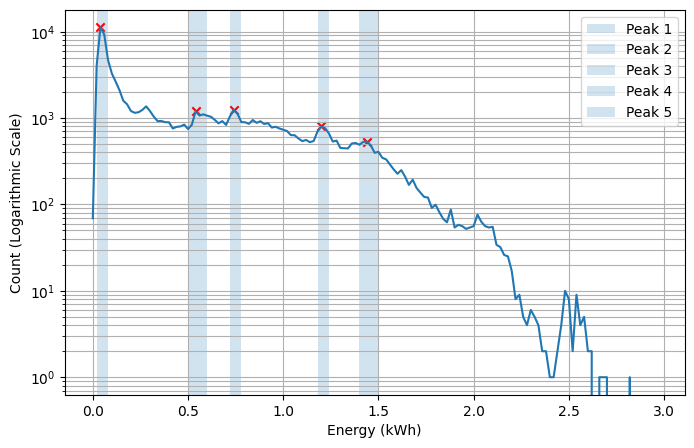

In [ ]:
# define the bin width and number of bins of histogram
binwidth = 0.02  # kWh
bins = np.arange(0, 3, binwidth)

# calculate the distribution of energy values
df_smd_hist, _ = np.histogram(df_smd['Value'], bins=bins)

# require width of 2.5*0.02kWh = 50Wh
peaks, peak_properties = find_peaks(df_smd_hist, prominence=3, width=2.5)

# create figure
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(bins[:-1], df_smd_hist)

# mark regions around peaks in blue
i = 1
for p, w in zip(peaks, peak_properties['widths']):
  ax.axvspan(bins[int(p - w / 2) + 1], bins[int(p + w / 2) + 1], alpha=0.2, label='Peak {}'.format(i))
  i += 1

# mark peaks with read cross
ax.scatter(bins[peaks], df_smd_hist[peaks], color='red', marker='x')

# adjust formatting and show figure
ax.set_yscale('log')
ax.grid(which='both')
ax.legend()
ax.set_xlabel('Energy (kWh)')
ax.set_ylabel('Count (Logarithmic Scale)')
fig.show()

## Frequency-based methods for low-resolution data
Frequency-based methods are a useful way to unveil regular patterns in data. By applying a Fast Fourier transform to the smart meter data, the energy signal can be transformed from the time domain to the frequency domain. This way the regularity of a signal can be observed.


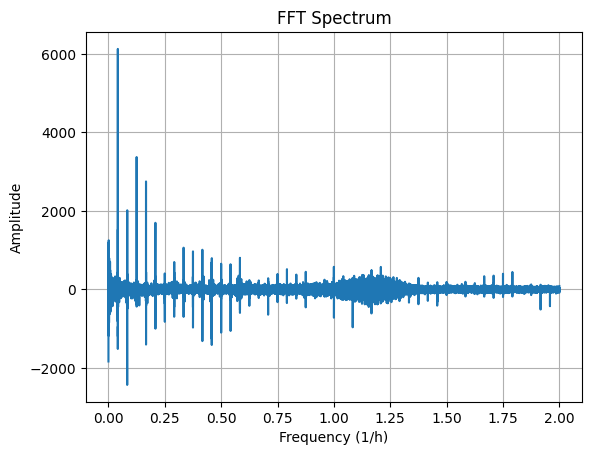

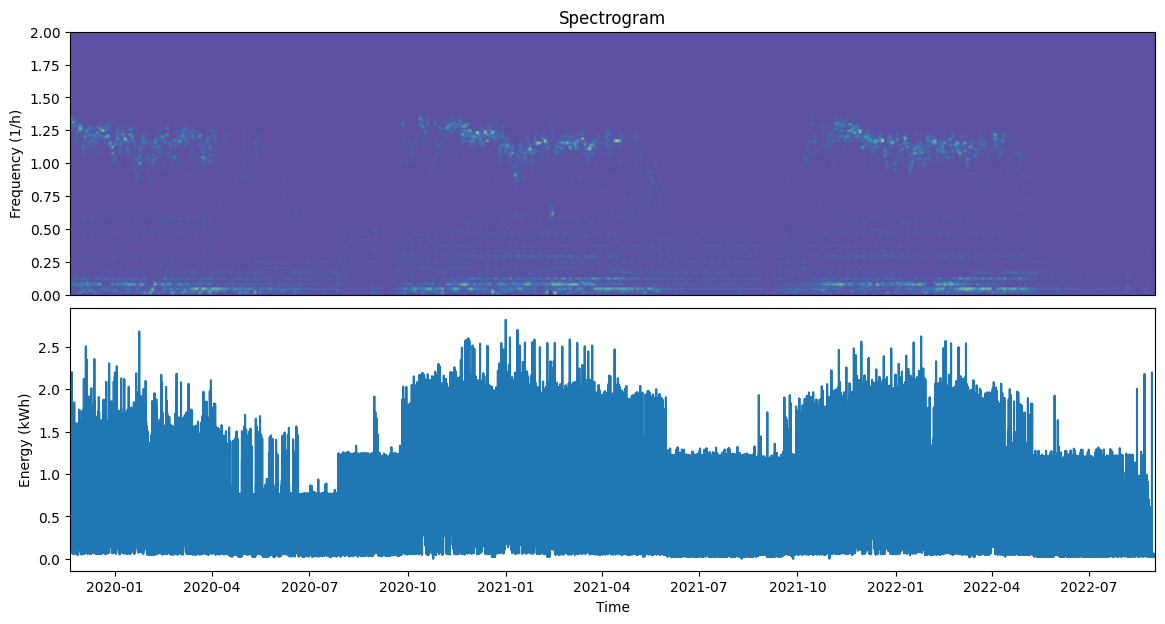

In [ ]:
from scipy.fft import fft, fftfreq
from scipy import signal

# define time sampling interval in hours
T = 0.25

# calculate fft
yf = fft(df_smd['Value'].to_numpy()).real
# calculate fft frequencies
xf = fftfreq(len(df_smd), T)[:len(df_smd) // 2]

# plot fft (excluding fist data point)
fig, ax = plt.subplots()
ax.plot(xf[1:len(df_smd) // 2], yf[1:len(df_smd) // 2])
ax.set_xlabel('Frequency (1/h)')
ax.set_ylabel('Amplitude')
ax.set_title('FFT Spectrum')
ax.grid()
fig.show()

# plot spectrogram
fig, ax = plt.subplots(2, 1, figsize=(14, 7), sharex=False)
# sample frequency in 1 / hours
fs = 1 / 0.25
f, t, Sxx = spectrogram(df_smd['Value'].to_numpy(), fs)
ax[0].pcolormesh(t, f, Sxx, shading='gouraud', cmap='Spectral_r')
ax[0].set_ylabel('Frequency (1/h)')
ax[0].set_title('Spectrogram')
ax[0].set_xticks([])
# plot original data for comparison
ax[1].plot(df_smd['Value'])
ax[1].set_xlim(df_smd.index[0], df_smd.index[-1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Energy (kWh)')

fig.subplots_adjust(hspace=0.05)
fig.show()

The spectogram shows the periodic peaks in the real part and a pronounced rise in amplitude at a period of 45 min (0.75h) to 1h. This activity can especially be observed in winter because it is caused by the heat pump.

## Non-Intrusive Load Monitoring (NILM)/Load Disaggregation
Non-Intrusive Load Monitoring (NILM), also known as load disaggregation, addresses the extraction of device-specific loads from measurements that combine multiple loads. Using the features and pre-processing methods to extract the energy consumption of the heat pump from the total consumption.

In NILM, the goal is to determine which appliances are operating at any given time and how much energy each is consuming, without requiring individual sensors on each device.

## Key Concepts

1. Multi-Label Classification
- In the context of NILM, multi-label classification means that the system must identify the presence or absence of multiple appliances simultaneously. For example, a household might have refrigerator, washing machine, and TV all operating at once. The NILM system must recognize all these active appliances from the aggregated signal.

2. Disaggregation
- Disaggregation involves breaking down the total energy consumption into its constituent parts, corresponding to individual appliances. This is done by analysing patterns in the aggreagated signal, such as changes in power consumption, harmonics, or transient events, which are characteristic of specific appliances.


### Techniques Used:
1. Machine Learning and Deep Learning
- Algorithms such as Hidden Markov Models (HMMs), Support Vector Machines (SVMs), and more recently, deep learning models like CNNs and RNNs are commonly used for NILM.
2. Feature Extraction:
- Techniques to extract meaningful features from the energy signal, such as power levels, harmonics, and transient events, are crucial for accurate disaggregation.
3. Ensemble Methods:
- Combining multiple models to improve the accuracy and robustness of the disaggregation process.


### Using classification algorithms to detect appliance installations
The data includes a separate column for heat pump consumption. Using the linear regression to determine heat pump consumption from total consumption. The model is trained with the first year data and tested with the rest of the data.


In [ ]:
# Use season features from above
df_add = add_descriptive_columns(df_smd, basic=False, seasons=True, weekday=False, daytime=False)
X = df_add[['Value', 'summer', 'winter', 'autumn', 'spring']].to_numpy()
y = df_add['Value_HeatPump'].to_numpy()

# Fit the linear regression model to the first year
reg = LinearRegression().fit(X[:365 * 96], y[:365 * 96])
# Predict rest of the data
y_pred = reg.predict(X[365 * 96:])

# Report performance and compare to a naive guess of no heat pump activity
print('Fit Score:', reg.score(X[:365 * 96], y[:365 * 96]))
print('MAE prediction:', mean_absolute_error(y_pred, y[365 * 96:]))
print('MAE naive:', mean_absolute_error(np.zeros_like(y[365 * 96:]), y[365 * 96:]))

Fit Score: 0.7794156685217568
MAE prediction: 0.13476094536540076
MAE naive: 0.3031268482365742


In [ ]:
df_add

Value  Value_HeatPump  Value_OtherAppliances  \
Timestamp                                                                 
2019-11-19 23:00:00+00:00  0.736           0.682                  0.054   
2019-11-19 23:15:00+00:00  1.216           1.126                  0.090   
2019-11-19 23:30:00+00:00  0.488           0.450                  0.038   
2019-11-19 23:45:00+00:00  0.065           0.023                  0.042   
2019-11-20 00:00:00+00:00  0.650           0.608                  0.042   
...                          ...             ...                    ...   
2022-08-31 20:45:00+00:00  0.052           0.000                  0.052   
2022-08-31 21:00:00+00:00  0.035           0.000                  0.035   
2022-08-31 21:15:00+00:00  0.031           0.000                  0.031   
2022-08-31 21:30:00+00:00  0.042           0.000                  0.042   
2022-08-31 21:45:00+00:00  0.043           0.000                  0.043   

                           season  winter  spring  summer  autumn  \
Timestamp                                                           
2019-11-19 23:00:00+00:00       4   False   False   False    True   
2019-11-19 23:15:00+00:00       4   False   False   False    True   
2019-11-19 23:30:00+00:00       4   False   False   False    True   
2019-11-19 23:45:00+00:00       4   False   False   False    True   
2019-11-20 00:00:00+00:00       4   False   False   False    True   
...                           ...     ...     ...     ...     ...   
2022-08-31 20:45:00+00:00       3   False   False    True   False   
2022-08-31 21:00:00+00:00       3   False   False    True   False   
2022-08-31 21:15:00+00:00       3   False   False    True   False   
2022-08-31 21:30:00+00:00       3   False   False    True   False   
2022-08-31 21:45:00+00:00       3   False   False    True   False   

                           transitionperiod  
Timestamp                                    
2019-11-19 23:00:00+00:00              True  
2019-11-19 23:15:00+00:00              True  
2019-11-19 23:30:00+00:00              True  
2019-11-19 23:45:00+00:00              True  
2019-11-20 00:00:00+00:00              True  
...                                     ...  
2022-08-31 20:45:00+00:00             False  
2022-08-31 21:00:00+00:00             False  
2022-08-31 21:15:00+00:00             False  
2022-08-31 21:30:00+00:00             False  
2022-08-31 21:45:00+00:00             False  

[97532 rows x 9 columns]

In [ ]:
df_add.to_csv('df_add.csv', index=True)

### Applying simple deep learning models for NILM
As a simple demontration of a more advanced machine learning approach, using a small neural network to perform disaggregation.

In [ ]:
from sklearn.neural_network import MLPRegressor

# Setup network model
reg = MLPRegressor(hidden_layer_sizes=(100, 100), solver='adam', random_state=1, max_iter=500)

# Fit training data
reg.fit(X[:365 * 96], y[:365 * 96])
# Predict rest of the data
y_pred = reg.predict(X[365 * 96:])

# Report performance
print('Fit Score:', reg.score(X[:365 * 96], y[:365 * 96]))
print('MAE prediction:', mean_absolute_error(y_pred, y[365 * 96:]))

Fit Score: 0.8107276743964554
MAE prediction: 0.11820212128730974


### Applying Hidden Markov Models for NILM
Since the disaggregation essentially attempts to estimate the operating state of a device from noisy observation of its demand, Hidden Markov Models (HMMs) are a promising method.
Reference: https://nbviewer.org/github/nilmtk/nilmtk/blob/v0.1.0/notebooks/fhmm.ipynb


### Correctly evaluating NILM approaches
The Python framework nimtk is an attempt to provide a unified interface and benchmarking of NILM approaches:
- parsers for eight common data sets
- a collection of pre-processing algorithms
- a set of statistics to describe datasets
- a set of reference benchmark disaggregation algorithms
- a common set of accuracy metrics

### Rule-based heuristics for pattern isolations
The advantage of such heuristics is that they are training-free and rather easy to implement. On the other hand, rule-based heuristics usually require more domain knowledge and experimental evaluation.
Our heuristics are based on the following assumptions:
- There is only one activation per night
- The consumption is above a threshold every day
- The consumption in each activation is constant
- The start times of the activation are the same (or similar) every day


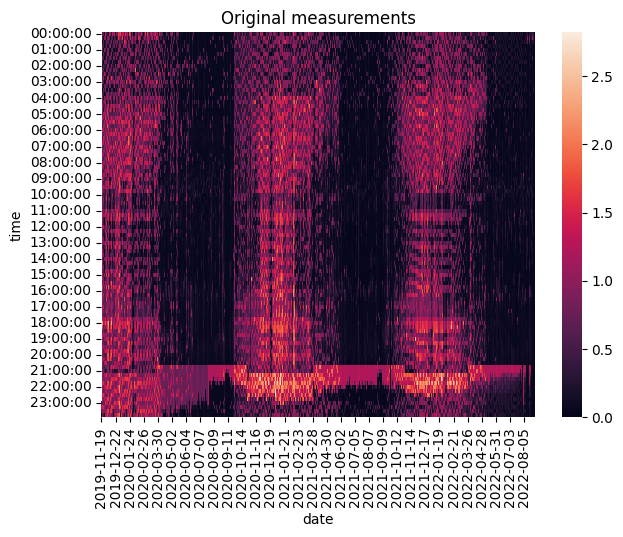

In [ ]:
# As we will add columns to the df, make a copy
df_disag = df_smd.copy()

# show heatmap
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(create_heatmap(df_disag, column='Value'), ax=ax)
ax.set_title('Original measurements')
fig.show()

We assume that the consumption during activation exceeds a certain minimum value. Therefore, we interpret this minimum as a threshold and apply a threshold filering to the data. This leaves us with what we call activation "plateaus", meaning that times of consumption above the threshold are separated by times of consumption below the threshold.



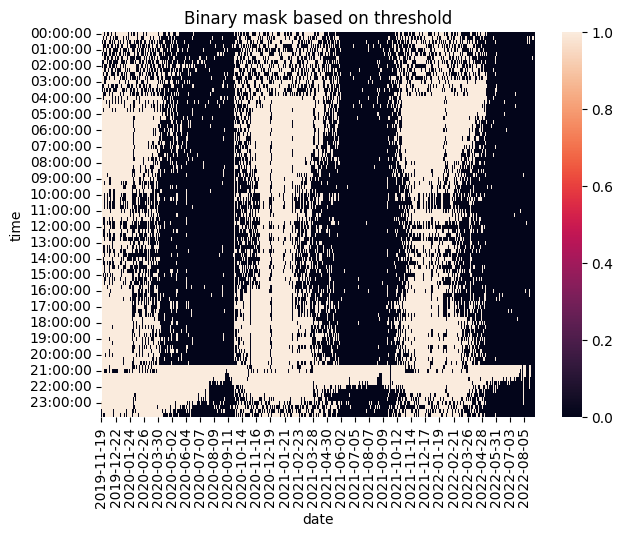

In [ ]:
# Threshold data at 0.5 kWh corresponding to a minium power of 2kW. We can derive this value from the height of the peak in the mean demand profile.
# Create a binary mask based on the thresholding.
df_disag['mask_threshold'] = (df_disag['Value'] > 0.5).astype(int)

# Plot the mask
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(create_heatmap(df_disag, column='mask_threshold'), ax=ax)
ax.set_title('Binary mask based on threshold')
fig.show()

Now, that the potential activation plateaus has been found, incorporating information about time. Recall that we aim to find activations that follow the prominent regular pattern in the late evening hours. Therefore, we extract the start times of each detected activation plateau.
Using a histogram of the time of day of activation times, we can determine the hour that has the most activations.


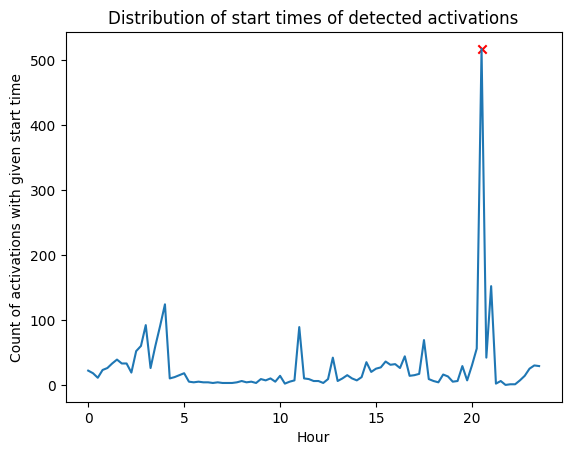

In [ ]:
# Shift data by 12 hours such that activations fall within the same day. This makes handling the data easier and we shift them back later.
df_disag.index += dt.timedelta(hours=12)

# In the binary mask, we find all "plateaus" - intervals of 1s separated by 0s
# We require the length to be at least 45 minutes
_, plateau_properties = find_peaks(df_disag['mask_threshold'], plateau_size=3, prominence=0.1)
# The left_edges of the plateaus are the times of the activations
left_edges = plateau_properties["left_edges"]

# Find the highest peak in the distribution of activation times. This will be the regular edge observed in the data.
bins = np.arange(0, 96)
hist, _ = np.histogram(df_disag.index[left_edges].hour * 4 + df_disag.index[left_edges].minute // 15, bins=bins)
peaks, peak_properties = find_peaks(hist, prominence=1)
peak_activation_time = peaks[peak_properties['prominences'].argmax()]

# Plot the distribution of start times and the identified peak.
fig, ax = plt.subplots()
# just for visualization we shift back the data
ax.plot(bins[:-1] / 4, list(hist[4 * 12 :]) + list(hist[:4 * 12]))
ax.scatter(bins[peak_activation_time + 4 * 12 - 1] / 4, hist[peak_activation_time], marker='x', color='r')
ax.set_title('Distribution of start times of detected activations')
ax.set_xlabel('Hour')
ax.set_ylabel('Count of activations with given start time')
fig.show()

Next, removing activations that start before the identified peak time because they are not interest anymore. Since it could happen from day to day the activation time deviates a little. Therefore, we still keep activations that start up to one hour before the identified peak time.

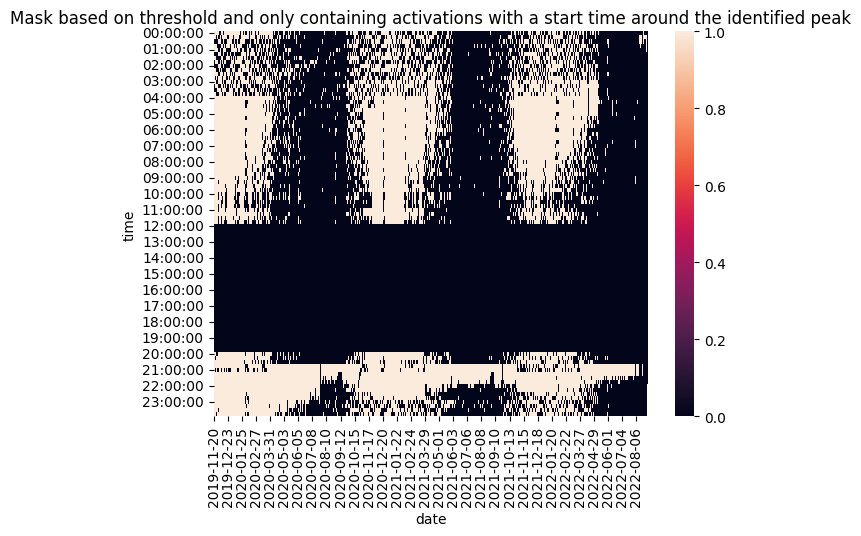

In [ ]:
# Set values before the edge to zero. We allow up to one hour before the peak
df_disag['mask_regularity'] = df_disag['mask_threshold']
df_disag.loc[df_disag.index.hour < peak_activation_time // 4, 'mask_regularity'] = 0
# Shift back the time for the plot
df_disag.index += dt.timedelta(hours=12)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(create_heatmap(df_disag, column='mask_regularity'), ax=ax)
ax.set_title('Mask based on threshold and only containing activations with a start time around the identified peak')
fig.show()

# shift the time forward again for further processing
df_disag.index += dt.timedelta(hours=12)

Since we have already removed many unwanted activations, all remaining plateaus in the mask start at the earliest around the determined activation time. Next, we are only interested in the first activation of each evening, since we assume that any subsequent activation relates to a different activity pattern.

<ipython-input-34-d39fab2ed611>:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.15000000000000002' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_disag.loc[timezone(TZ_LOCAL).localize(start):timezone(TZ_LOCAL).localize(end), 'profile'] = max(np.mean([diff_on, diff_off]), 0)


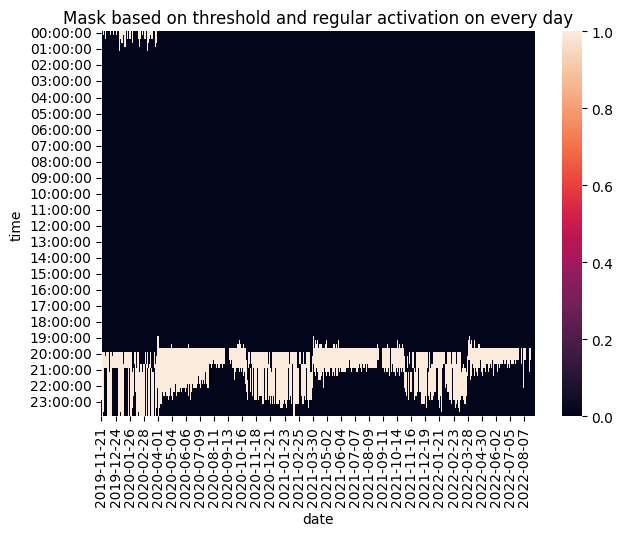

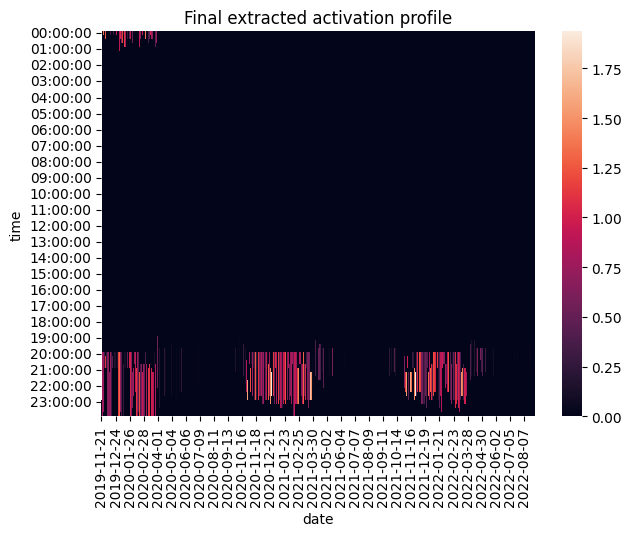

In [ ]:
# new column for the masked out data for every day
df_disag['mask_daily'] = 0
# new colum for the energy consumption of the regular activations
df_disag['profile'] = 0

# on each day re-calculate the plateaus
for date, df in df_disag.groupby([df_disag.index.date]):
  _, plateau_properties = find_peaks(df['mask_regularity'], plateau_size=3, prominence=0.1)
  left_edges = plateau_properties["left_edges"]
  right_edges = plateau_properties["right_edges"]

  # take the first plateau as the activation
  if len(left_edges) > 0:
    le = left_edges[0]
    ri = right_edges[0]
    # Extract the datetime.date object from the date tuple
    date_obj = date[0]
    start = dt.datetime.combine(date_obj, dt.time(hour=le // 4, minute=le % 4 * 15))
    end = dt.datetime.combine(date_obj, dt.time(hour=ri // 4, minute=ri % 4 * 15))
    df_disag.loc[timezone(TZ_LOCAL).localize(start):timezone(TZ_LOCAL).localize(end), 'mask_daily'] = 1

    # Estimate the consumption during the activation as the energy difference at switch-on and switch-off
    # This should capture the energy amount added by the activation.
    diff_on = df_disag.loc[timezone(TZ_LOCAL).localize(start) + dt.timedelta(minutes=15), 'Value'] \
           - df_disag.loc[timezone(TZ_LOCAL).localize(start) - dt.timedelta(minutes=15), 'Value']
    diff_off = df_disag.loc[timezone(TZ_LOCAL).localize(end) - dt.timedelta(minutes=15), 'Value'] \
           - df_disag.loc[timezone(TZ_LOCAL).localize(end) + dt.timedelta(minutes=15), 'Value']
    df_disag.loc[timezone(TZ_LOCAL).localize(start):timezone(TZ_LOCAL).localize(end), 'profile'] = max(np.mean([diff_on, diff_off]), 0)

# Shift back the time
df_disag.index += dt.timedelta(hours=12)

# Plot heatmaps
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(create_heatmap(df_disag, column='mask_daily'), ax=ax)
ax.set_title('Mask based on threshold and regular activation on every day')
fig.show()

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(create_heatmap(df_disag, column='profile'), ax=ax)
ax.set_title('Final extracted activation profile')
fig.show()

This leaves only a single activation per night with a constant value. The start times are regular, but we have allowed deviations of up to one hour to account for the fluctuations caused by the daylight saving time changeover.

## Flexibility Estimation


This concept refers to the postponing of consumption from appliances to stablize the power grid. An example of this is to delay the operation of a heating system or to defer the charging of an electric vehicle during periods of high demand. Even further, the operation of such devices can be coordinated with local solar or wind generation, if available.

In the following, we estimate the flexibility of water heating in the sample household. To do this, we use patterns we isolated earlier. These regular high demand patterns are generated by a boiler that runs only once a day. A typical hot water boilder can easily store heat throughout the day and therefore has inherent heat storage. This makes it ideal for shifting hot water production to other times of the day without sacrificing comfort for the owner.

### Estimating load shifting potentical of disaggregated appliances
To estimate the impact of the boilder on household demand, calculating its share of daily energy demand and its contribution to peak demand.

<ipython-input-35-a27efe4c57d9>:25: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  daily_peak_mask = df_disag.groupby([df_disag.index.date])['Value'].transform(max) == df_disag['Value']


Share of boiler consumption: 0.06311473716293899
Peak reduction without boiler: 1.0


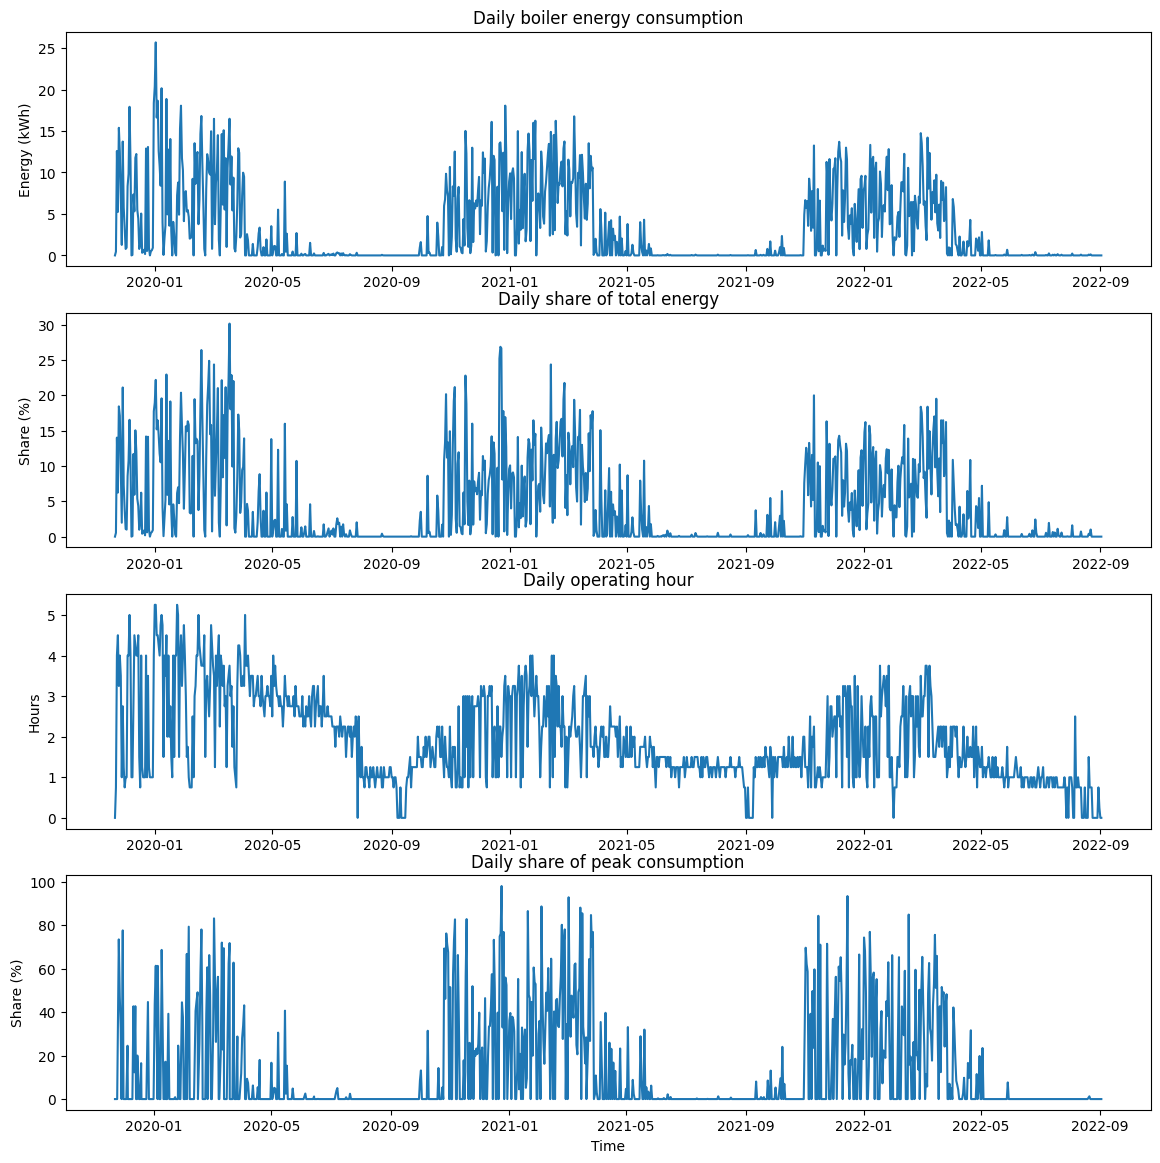

In [ ]:
# Calculate daily values
# here we could use outlier detection to make sure our disaggregation result are reasonable
daily_boiler = calculate_daily_consumption(df_disag, column='profile')
daily_total = calculate_daily_consumption(df_disag, column='Value')

fig, ax = plt.subplots(4, 1, figsize=(14, 14))

# Daily energy
ax[0].plot(daily_boiler)
ax[0].set_ylabel('Energy (kWh)')
ax[0].set_title('Daily boiler energy consumption')

# Daily energy share
ax[1].plot(daily_boiler / daily_total * 100)
ax[1].set_ylabel('Share (%)')
ax[1].set_title('Daily share of total energy')

# Daily operating hours
ax[2].plot(df_disag.groupby([df_disag.index.date])['mask_daily'].sum() / 4)
ax[2].set_ylabel('Hours')
ax[2].set_title('Daily operating hour')

# Daily peak contribution (percent of demand at peak of day)
# get the index of the peak on every day
daily_peak_mask = df_disag.groupby([df_disag.index.date])['Value'].transform(max) == df_disag['Value']
# plot the share of boiler consumption during the peak times
ax[3].plot((df_disag['profile'] / df_disag['Value'])[daily_peak_mask] * 100)
ax[3].set_ylabel('Share (%)')
ax[3].set_title('Daily share of peak consumption')

ax[-1].set_xlabel('Time')
fig.show()


# Calculate metrics for full time span
print('Share of boiler consumption:', df_disag['profile'].sum() / df_disag['Value'].sum())
print('Peak reduction without boiler:', (df_disag['Value'] - df_disag['profile']).max() / df_disag['Value'].max())

The daily boilder demand ranges from about 5 kWh/day in summer to 15 kWh/day in winter, with occasionally much higher demand which might partially be caused by errors in the disaggregation. While this demand is only about 10% of total consumption in winter, it is up to 50% of total daily household consumption in summer. This difference is due to the high electricity demand for heating in winter.
The results show that a significant portion of a household's electricity consumption is available for easy and trouble-free shifting by controlling the times for boiler activation during the day.
We can also look at the peak electricity consumption of the household with and without the boiler. This ratio is especially important of the power grid, as transformer stations and connecting lines must be dimensioned for the highest power consumption, even if it is only reached on few occasions.
Although seeing over the entire period that we would have a similar peak without the boiler, we also find that the boiler is very often responsible for the highest peak. Since it is unlikely that the natural peaks of multiple households will coincide, reducing the peak of the boiler has a significant impact on the overall peaks in a community.

# Anomaly Detection
In the context of energy data, potential application scenarios are the recognition of atypical occupancy, energy theft, broken appliances, or unusually high energy consumption in order to inform the affected households.

## Introduction to online vs. offline change point detection
In the context of energy consumption, there are many reasons that can cause noticeable change points to be observed in smart meter data. For example:
- the installation of a new appliance
- changes in oocupancy
- a malfunction in the heating system
- electricity theft

Change point detection (CPD) methods can be categorised as follows:
- Offline CPD: Looking at the entire data set at once; looking back in time to identify all change points.
- Online CPD: continuous observation over time and identifying change points in real time.

## Finding state changes with offline change point detection

At each time point, the time series is split into a time series before and after the current observation. By comparing the distributions before and after, the difference between the distributions can be determined using various functions (for example, the simplest would be something like the absolute difference of the means). Change points are then points where the change in the distribution is very noticable.

Changepoint 1 at: 2020-01-30 10:00:00+00:00
Changepoint 2 at: 2020-02-27 23:00:00+00:00


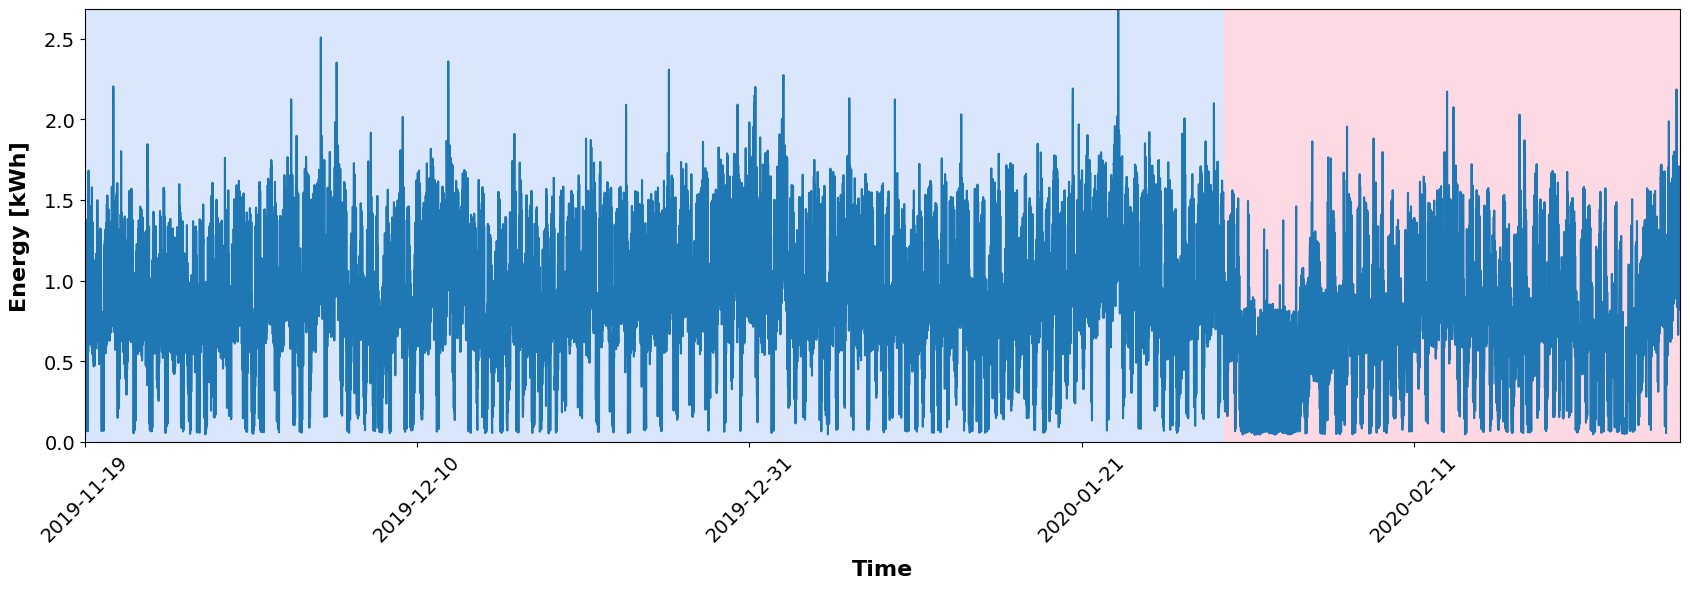

In [ ]:
import ruptures as rpt

# ----------------------------
# APPLY CHANGE POINT DETECTION
# ----------------------------

# the number of days from the start of the data frame, you want to look at
# NOTE: we added this because for a large number of observations, the calculation can become quite slow
days = 100

# extract the signal, i.e. values of energy consumption
signal = df_smd['Value'].values[:96*days]

# define the number of break points to be determined
n_bkps = 1

# try out different algorithms
# algo = rpt.Dynp(model='l2').fit(signal)
# algo = rpt.Dynp(model="rank").fit(signal)
algo = rpt.Binseg(model='l2').fit(signal)

# determine the break points
bkps = algo.predict(n_bkps=n_bkps)

# get the timestamps of the change points
bkps_timestamps = [df_smd.index[e] for e in bkps]
for idx, e in enumerate(bkps_timestamps):
    print('Changepoint {} at: {}'.format(idx+1, e))

# ----------------------------
# VISUALIZE RESULTS
# ----------------------------

# show results as plot
fig, ax = rpt.display(signal, bkps, figsize=(17, 6))

# as the original plot does not show the timestamps, let's add them
xticks = ax[0].get_xticks()
xtick_labels = df_smd.iloc[xticks].index.strftime('%Y-%m-%d').values
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xtick_labels, fontsize=14, rotation=45)
ax[0].set_xlim(0, 96*days+1)
ax[0].set_xlabel('Time', fontsize=16, fontweight='bold', labelpad=10)

# adjust y-axis
ax[0].set_yticks(ax[0].get_yticks())
ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=14)
ax[0].set_ylabel('Energy [kWh]', fontsize=16, fontweight='bold', labelpad=10)
ax[0].set_ylim(0, np.max(signal))

plt.tight_layout()
plt.show()

## Finding anomalies with sliding window

Number of anomalies found: 14


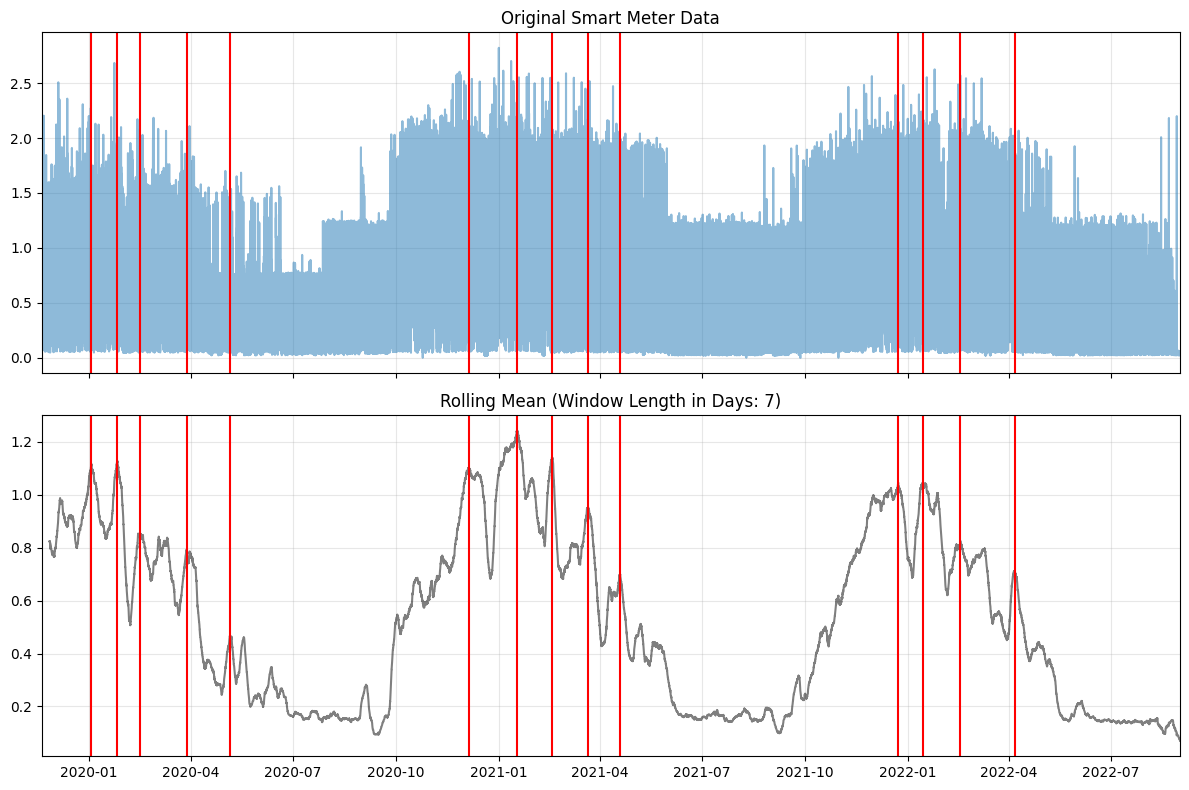

In [ ]:
# ----------------------------
# ANOMALY DETECTION WITH ROLLING MEAN
# ----------------------------

# do this when wanting to see the whole time series
df_sub = df_smd.copy()

# apply sliding window with rolling mean
window_days = 7
prominence = 0.2

df_sub['rolling_mean'] = df_sub['Value'].rolling(int(window_days*96)).mean()
vals = df_sub['rolling_mean'].values

# find peaks
anomaly_indices = find_peaks(vals, prominence=prominence)[0]
anomaly_timestamps = df_sub.iloc[anomaly_indices].index.values
anomaly_values = df_sub.iloc[anomaly_indices]['Value'].values
print('Number of anomalies found: {}'.format(len(anomaly_indices)))

# ----------------------------
# VISUALIZE RESULTS
# ----------------------------

# create figure
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)

# plot the original signal
ax[0].plot(df_sub.index.values, df_sub['Value'].values, alpha=0.5)
ax[0].set_title('Original Smart Meter Data')
for e in anomaly_timestamps:
    ax[0].axvline(x=e, color='red')
ax[0].grid(alpha=0.3)
ax[0].set_xlim(df_sub.index.min(), df_sub.index.max())

# plot the anomaly scores
ax[1].plot(df_sub.index.values, vals, color='black', alpha=0.5)
ax[1].set_title('Rolling Mean (Window Length in Days: {})'.format(window_days))
for e in anomaly_timestamps:
    ax[1].axvline(x=e, color='red')
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Applying Symbolic Aggregate ApproXimation
1. Normalisation: the time series is normalised (typically with Z-score normalisation)
2. Breakpoints: the range of value is divided into equiprobable regions based on Gaussian distribution. The regions are separated by breakpoints - their calculation depends on the selected alphabet size.
3. Chunking: The time series is broken down into individual subsequences (can also be based on a sliding window approach). The chunks are represented by the vertical lines.
4. Averaging: The average of the individual subsequences is calculated.
5. Assignment of characters: each mean value of a subsequence is assigned to an alphabetic character corresponding horizontal breakpoint. Therefore, the mean values of each chunk are assigned to the three letters a, b and c.

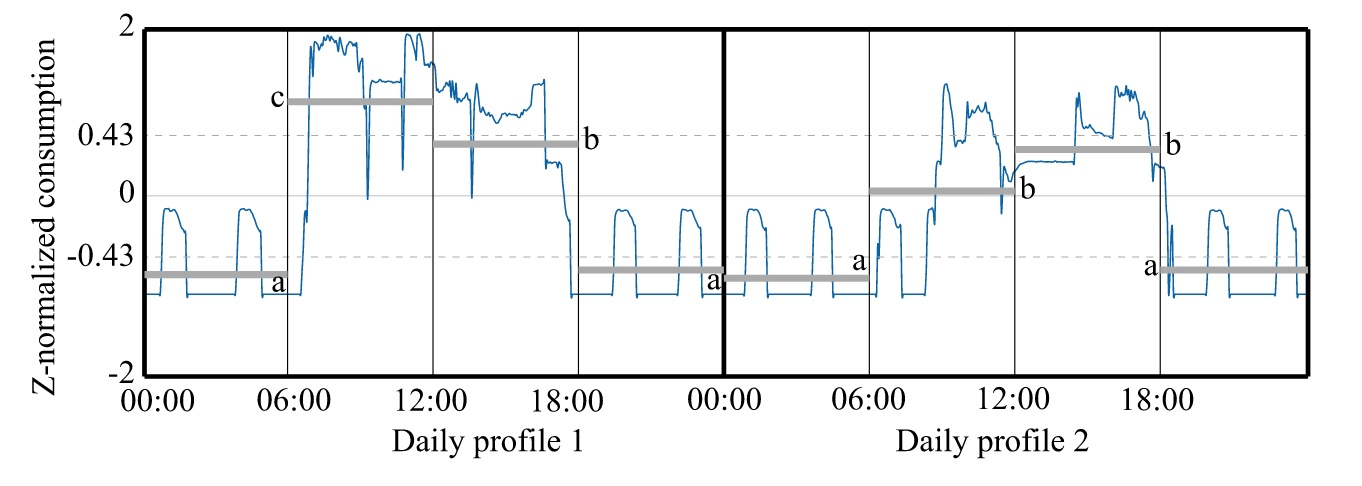

In [ ]:
!pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 7.7 MB/s eta 0:00:00


In [ ]:
from pyts.approximation import SymbolicAggregateApproximation
from pyts.preprocessing import StandardScaler
from collections import Counter

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyts.approximation import SymbolicAggregateApproximation
from pyts.preprocessing import StandardScaler
from collections import Counter

# Example smart meter data (replace with your actual data)
# Assuming df_smd is a DataFrame with a 'Value' column
days = 7
np_vals = df_smd['Value'].values[:96 * days]  # Select 7 days of data (96 samples per day)

# Set parameters
win_size = 8       # Window size
paa_size = 4       # PAA size
alphabet_size = 3  # Alphabet size
z_threshold = 0.01 # Z-normalization threshold

# Z-normalize the data (if required)
scaler = StandardScaler()
np_vals_scaled = scaler.fit_transform(np_vals.reshape(1, -1)).flatten()

# Sliding window function
def sliding_window(series, window_size):
    return np.array([series[i:i + window_size] for i in range(len(series) - window_size + 1)])

# Apply sliding window
windows = sliding_window(np_vals_scaled, win_size)

# SAX transformation
sax = SymbolicAggregateApproximation(n_bins=alphabet_size, strategy='uniform', alphabet='ordinal')
sax_words = sax.fit_transform(windows)

# Convert SAX words to strings
sax_words = [''.join(map(str, word)) for word in sax_words.astype(int)]

# Count occurrences of each SAX word
sax_statistics = Counter(sax_words)

# Sort SAX words by frequency for better visualization
sax_statistics_sorted = dict(sorted(sax_statistics.items(), key=lambda item: item[1], reverse=True))

# Limit the number of SAX words displayed (e.g., top 20)

sax_statistics_sorted = dict(list(sax_statistics_sorted.items())[:top_n])

# Plot a horizontal bar plot for better readability
fig, ax = plt.subplots(figsize=(10, 8))

# Horizontal bar plot
ax.barh(list(sax_statistics_sorted.keys()), sax_statistics_sorted.values(), color='skyblue')

# Customize the plot
ax.set_xlabel('Frequency', fontsize=14)
ax.set_ylabel('SAX Words', fontsize=14)
ax.set_title(f'Top {top_n} Most Frequent SAX Words', fontsize=16)
ax.tick_params(axis='y', which='major', labelsize=12)
ax.grid(alpha=0.3)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

NameError: name 'top_n' is not defined

In [ ]:
print(sax_statistics_sorted)

{'02002002': 21, '20020020': 16, '00200200': 16, '20220220': 13, '02102102': 12, '02202202': 11, '20020021': 9, '22022022': 8, '21021021': 8, '10200200': 7, '00200210': 7, '20210210': 6, '02102002': 6, '10210210': 6, '02102202': 5, '10220210': 5, '21021020': 5, '21020020': 5, '00000012': 5, '02002102': 5, '01200200': 5, '01101212': 4, '10220220': 4, '00001220': 4, '02202200': 4, '10210200': 4, '12101101': 3, '21011011': 3, '22022021': 3, '20220210': 3, '00210110': 3, '21022022': 3, '21022021': 3, '02202102': 3, '02002000': 3, '20020000': 3, '00012201': 3, '00122011': 3, '01220110': 3, '02202201': 3, '21110110': 3, '20020120': 3, '10210220': 3, '10200210': 3, '20021021': 3, '00210210': 3, '10000120': 3, '00001200': 3, '11012122': 3, '22002002': 3, '02201201': 3, '20120120': 3, '12012002': 3, '12002002': 3, '12002001': 3, '20020011': 3, '20220120': 3, '01002101': 2, '02101101': 2, '21011012': 2, '01102212': 2, '01201101': 2, '22021021': 2, '20000121': 2, '20110220': 2, '21021022': 2, '00

## Finding discords and motifs
SAX can be useful way to distinguish between discords and motifs:
- Motifs: a subsequence of data that exhibits a pattern that frequently occurs in a data stream
- Discords: a subsequence that occurs rarely and is considered anomalous amongst the rest of the data set.

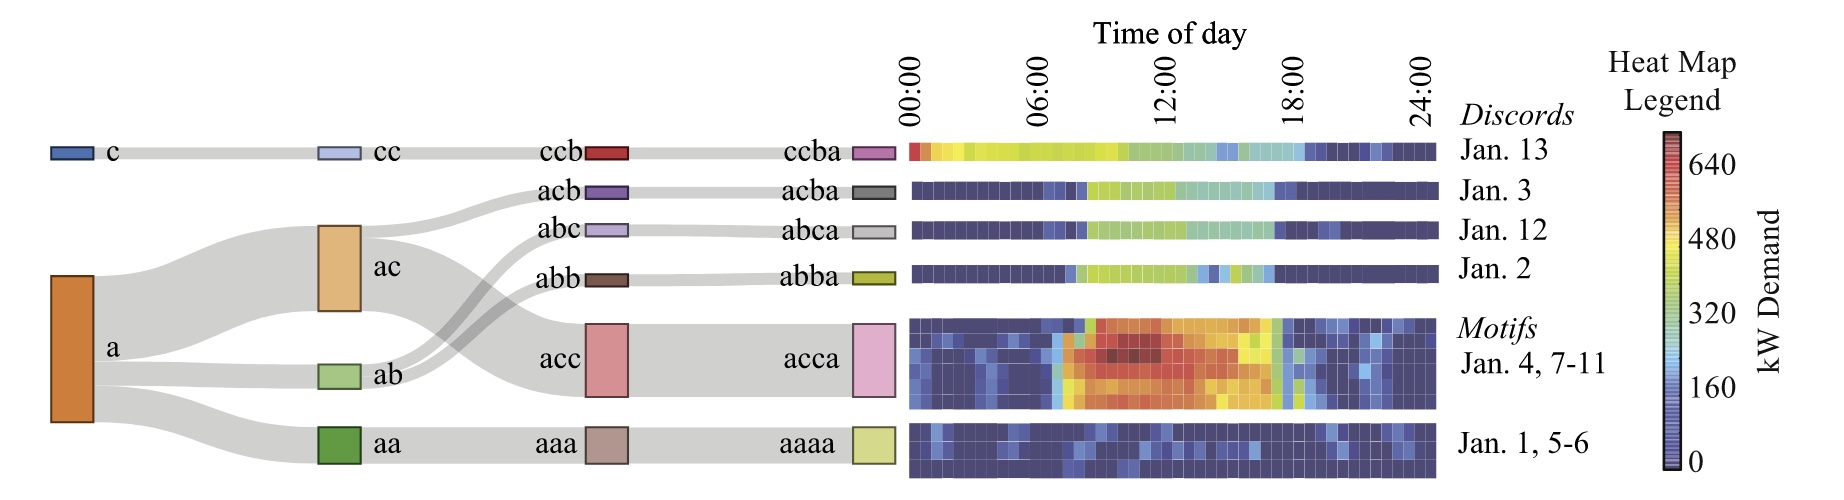

In [ ]:
!pip install stumpy
import stumpy

In [ ]:
# Function for finding discords (adapted from stumpy documentation)
def find_discords_hotsax(ts, win_size, paa_size, a_size, num_discords=2, nr_strategy="exact"):
    """
    Find discords using SAX representation and HOTSAX algorithm.

    Args:
        ts: Time series data.
        win_size: Window size for SAX transformation.
        paa_size: PAA size for SAX transformation.
        a_size: Alphabet size for SAX transformation.
        num_discords: Number of discords to find.
        nr_strategy: Numerosity reduction strategy ('exact' or 'random').

    Returns:
        List of discords (start index, end index, discord distance).
    """
    # Z-normalize the data
    scaler = StandardScaler()
    ts_scaled = scaler.fit_transform(ts.reshape(1, -1)).flatten()

    # Sliding window function
    def sliding_window(series, window_size):
        return np.array([series[i : i + window_size] for i in range(len(series) - window_size + 1)])

    # Apply sliding window
    windows = sliding_window(ts_scaled, win_size)

    # SAX transformation
    sax = SymbolicAggregateApproximation(n_bins=a_size, strategy="uniform", alphabet="ordinal")
    sax_words = sax.fit_transform(windows)

    # Convert SAX words to float64 for stumpy.stump
    sax_words_numeric = sax_words.astype(np.float64)

    # Find discords using stumpy
    discords = []
    for i in range(num_discords):
        mp = stumpy.stump(sax_words_numeric, win_size, ignore_trivial=False)
        discord_index = np.argmax(mp[:, 0])
        discords.append((discord_index, discord_index + win_size - 1))

    return discords

# ------------------
# VISUALIZE
# ------------------
# Example time series data (replace with your actual data)
np_vals = np.random.rand(1000)  # Replace with your actual time series data
win_size = 8  # Window size

# Generate timestamps (replace with your actual timestamps)
np_timestamps = np.arange(len(np_vals))  # Example: Use indices as timestamps

# Find discords
indices = find_discords_hotsax(np_vals, win_size=win_size, paa_size=4, a_size=3, num_discords=6)

# Create figure
fig, ax = plt.subplots(figsize=(12, 4))

# Plot time series
ax.plot(np_timestamps, np_vals, color='blue', label='Time Series')

# Mark discords
for start, stop in indices:
    ax.axvspan(np_timestamps[start], np_timestamps[stop + 1], color='red', alpha=0.3, label='Discord' if start == indices[0][0] else "")

# Customize plot
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlabel('Time', fontsize=14, fontweight='bold')
ax.set_ylabel('Energy (kWh)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

ValueError: T_A is 2-dimensional and must be 1-dimensional. For multidimensional STUMP use `stumpy.mstump` or `stumpy.mstumped`

# Customer Segmentation

For utilties it is usually of interest to divide their customer base into different groups, eg: high and low consumption customers, or in more sophisticated form, customers with similar appliance installations or patterns.

## Extraction of energy signatures through regression
Energy signatures describe the relationship between the energy consumption of a building and the outdoor air temperature. They can basically be understood as simple scatter plots, where the:
- x-axis: represents the outdoor air temperature.
- y-axis: represents the energy consumption of the building
The scatter plot shape makes it possible to estimate the energy effiency of the building and simple features such as the heating system.

The steps we perform are:
1. Downsampling: we calculate the average energy consumption per day.
2. Combining with weather data: combine the average outdoor temperatures and the daily energy data.
3. Normalisation: normalise the daily energy data using the default scaler
4. Fitting a nonlinear regression model: perform a grid search and fit a nonlinear support vector regression model
5. Energy signature profile - resampling: using the fitted model, we sample between the min and max observed temperatures in 0.5 degree celsius increments. The result is a vector that defines the energy signature profile.

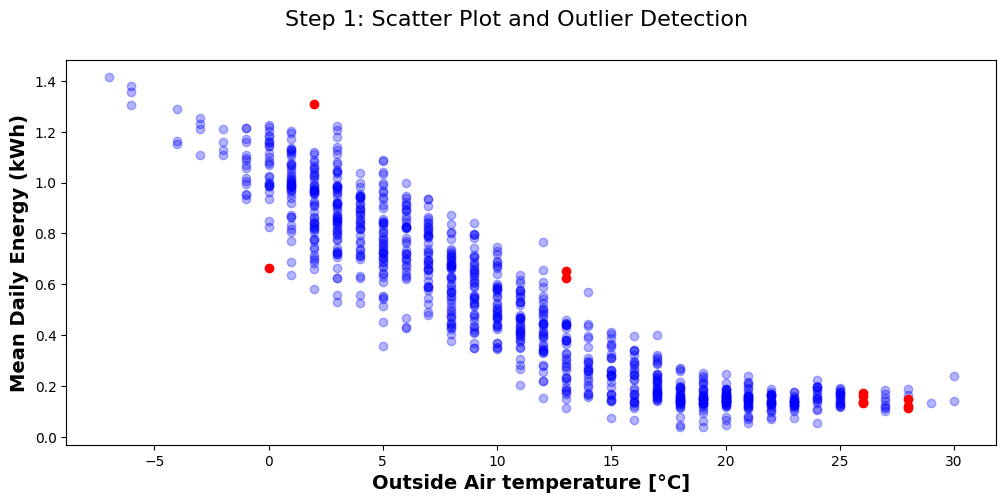

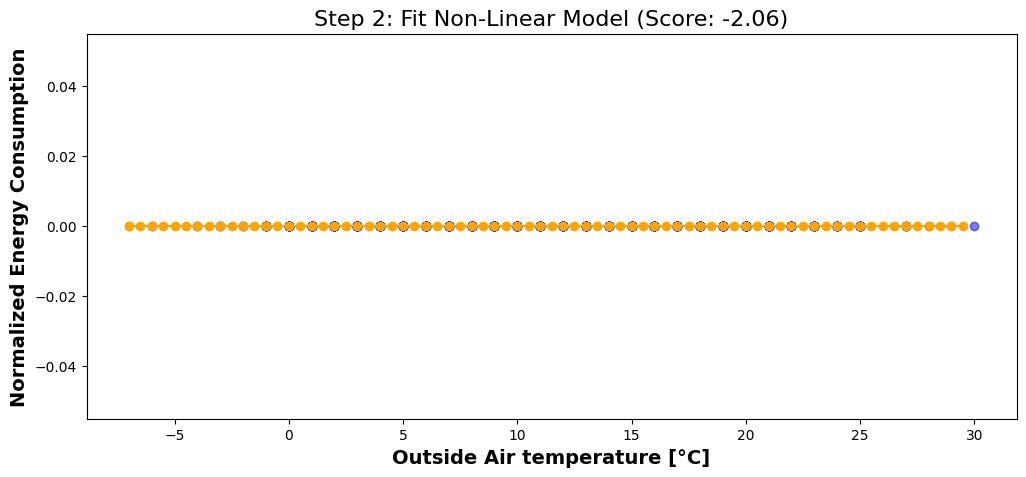

In [ ]:
# ---------------------------
# STEP 1: OUTLIER ELIMINATION
# ---------------------------

# downsample the energy data to daily resolution
df_resampled = df_smd.resample('1D').mean()

# combine daily energy data with daily temperature data
df_combined = merge_smd_with_weather(df_resampled, df_weather_daily, hourly=False)
df_combined = df_combined[['Value', 'daily_avgtemp']].dropna()

# extract the energy and temperature readings
np_energy = df_combined['Value'].values
np_temp = df_combined['daily_avgtemp'].values

# detect outliers
y_pred = LocalOutlierFactor(n_neighbors=5, contamination=0.01).fit_predict(np.vstack((np_temp, np_energy)).T)

# NOTE: now y_pred is a vector referring to the indices of np_energy and np_temp
# NOTE: an outlier is marked with a value of -1 and an inlier with a value of 1
# let's replace these by boolean values and assign them to the pandas data frame
y_pred[y_pred==1] = False
y_pred[y_pred==-1] = True
df_combined['Outlier'] = y_pred.astype(bool)

# -------------------------------------
# VISUALIZE STEP 1: OUTLIER ELIMINATION
# -------------------------------------

fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(df_combined[df_combined['Outlier']==False]['daily_avgtemp'], df_combined[df_combined['Outlier']==False]['Value'], color='blue', alpha=0.3)
ax.scatter(df_combined[df_combined['Outlier']==True]['daily_avgtemp'], df_combined[df_combined['Outlier']==True]['Value'], color='red')
ax.set_xlabel('Outside Air temperature [°C]', fontsize=14, fontweight='bold')
ax.set_ylabel('Mean Daily Energy (kWh)', fontsize=14, fontweight='bold')
fig.suptitle('Step 1: Scatter Plot and Outlier Detection', fontsize=16)
plt.show()

# ---------------------------
# STEP 2: FIT NON-LINEAR MODEL
# ---------------------------

# now use only the non-outlier points
np_energy = df_combined[df_combined['Outlier'] == False]['Value'].values.reshape(-1,1)
np_temp = df_combined[df_combined['Outlier'] == False]['daily_avgtemp'].values.reshape(-1,1)

# normalize energy values
scaler = StandardScaler().fit(np_energy)
np_energy = scaler.transform(np_energy).reshape(-1, 1)

# define a grid searach to find the best parameters
svr = GridSearchCV(SVR(kernel='rbf', epsilon=.3), cv=5, param_grid={"C": [10e0, 10e1], "gamma": np.logspace(-2, -2, 8)})

# perform the grid search and non-linear fit
svr.fit(np_temp, np_energy.ravel())

# choose best model from grid search and get corresponding score
model = svr.best_estimator_
score = r2_score(np_temp, svr.predict(np_energy))

# sample the energy signature between minimum and maximum observed temperature in 0.5 steps
x_hat = np.arange(np.floor(np_temp.min()), np.ceil(np_temp.max()), .5).reshape(-1, 1)

# create the energy signature profile by predicting for each
df_energy_signature = pd.DataFrame(np.transpose([x_hat.ravel(), model.predict(x_hat)]),columns=['Temperature', 'Usage_hat'])

# --------------------------------------
# VISUALIZE STEP 2: FIT NON-LINEAR MODEL
# --------------------------------------
plt.figure(figsize=(12,5))
plt.plot(np_temp, np_energy, 'o', color='blue', alpha=0.3)
plt.plot(x_hat, df_energy_signature['Usage_hat'], '-o', color='orange')
plt.ylabel('Normalized Energy Consumption', fontsize=14, fontweight='bold')
plt.xlabel('Outside Air temperature [°C]', fontsize=14, fontweight='bold')
plt.title('Step 2: Fit Non-Linear Model (Score: {})'.format(np.round(score, 2)), fontsize=16)
plt.show()


## Extraction of average day profiles
Both the energy signature profile and average daily profile shown above can be computed for multiple households. If we apply a clustering algorithm to either the average daily profiles or the energy signature profiles, we can cluster and group households according to their similarities.

Using a subset of 1000 households and calculate only the average daily profiles for the month of July.

In [ ]:
display(df_profiles)

0      1      2      3      4      5  \
id                                                                           
05799b091d77acb8963bc4f189cbbc94  0.021  0.020  0.018  0.015  0.014  0.014   
057c30dbdc165d5dbc8dfaba85be5be7  0.566  0.557  0.799  0.908  0.822  0.770   
057c3fcbdcbfd97b9f8a50fb34f385d6  0.014  0.013  0.013  0.015  0.015  0.013   
057d57d2e17e556e76045ec53f58beb2  0.459  0.342  0.286  0.342  0.900  0.858   
057d990ed2aee058d63f15f30443f9e4  0.631  0.624  0.624  0.620  0.629  0.634   
...                                 ...    ...    ...    ...    ...    ...   
a42793c65fddea7c1f8228f8d4742635  0.086  0.126  0.101  0.084  0.093  0.082   
a427d8292c36aadbf48269008ce844b3  0.620  0.480  0.437  0.522  0.842  0.413   
a428b13bc581d14804c35c1f6b4169be  2.800  3.114  3.097  2.848  2.614  2.765   
a429fd879fe72a1660cbd364cced304b  0.463  0.482  0.457  0.443  0.497  0.480   
a42a3bba9dcf618c93b5cbb32da24a32  0.445  0.509  0.362  0.367  0.754  0.709   

                                      6      7      8      9  ...     86  \
id                                                            ...          
05799b091d77acb8963bc4f189cbbc94  0.013  0.012  0.013  0.013  ...  0.056   
057c30dbdc165d5dbc8dfaba85be5be7  0.658  0.609  0.934  0.931  ...  0.040   
057c3fcbdcbfd97b9f8a50fb34f385d6  0.013  0.015  0.015  0.014  ...  0.037   
057d57d2e17e556e76045ec53f58beb2  0.660  0.592  0.521  0.160  ...  0.113   
057d990ed2aee058d63f15f30443f9e4  0.632  0.634  0.638  0.632  ...  0.632   
...                                 ...    ...    ...    ...  ...    ...   
a42793c65fddea7c1f8228f8d4742635  0.082  0.087  0.079  0.075  ...  0.166   
a427d8292c36aadbf48269008ce844b3  0.439  0.400  0.406  0.353  ...  0.476   
a428b13bc581d14804c35c1f6b4169be  2.877  3.013  3.371  2.895  ...  0.441   
a429fd879fe72a1660cbd364cced304b  0.531  0.475  0.398  0.283  ...  0.137   
a42a3bba9dcf618c93b5cbb32da24a32  0.681  0.273  0.224  0.117  ...  0.130   

                                     87     88     89     90     91     92  \
id                                                                           
05799b091d77acb8963bc4f189cbbc94  0.054  0.044  0.040  0.037  0.033  0.029   
057c30dbdc165d5dbc8dfaba85be5be7  0.040  0.581  0.752  0.773  0.782  0.713   
057c3fcbdcbfd97b9f8a50fb34f385d6  0.034  0.033  0.034  0.032  0.029  0.025   
057d57d2e17e556e76045ec53f58beb2  0.180  0.727  0.723  0.719  0.529  0.431   
057d990ed2aee058d63f15f30443f9e4  0.618  0.612  0.617  0.624  0.622  0.624   
...                                 ...    ...    ...    ...    ...    ...   
a42793c65fddea7c1f8228f8d4742635  0.163  0.176  0.193  0.166  0.136  0.142   
a427d8292c36aadbf48269008ce844b3  0.593  0.847  0.579  0.580  0.537  0.632   
a428b13bc581d14804c35c1f6b4169be  0.629  0.974  1.541  1.746  1.910  1.880   
a429fd879fe72a1660cbd364cced304b  0.189  0.417  0.357  0.374  0.369  0.232   
a42a3bba9dcf618c93b5cbb32da24a32  0.119  0.118  0.127  0.108  0.132  0.452   

                                     93     94     95  
id                                                     
05799b091d77acb8963bc4f189cbbc94  0.024  0.023  0.022  
057c30dbdc165d5dbc8dfaba85be5be7  0.563  0.470  0.528  
057c3fcbdcbfd97b9f8a50fb34f385d6  0.024  0.021  0.018  
057d57d2e17e556e76045ec53f58beb2  0.471  0.488  0.518  
057d990ed2aee058d63f15f30443f9e4  0.634  0.632  0.636  
...                                 ...    ...    ...  
a42793c65fddea7c1f8228f8d4742635  0.068  0.058  0.069  
a427d8292c36aadbf48269008ce844b3  0.433  0.415  0.438  
a428b13bc581d14804c35c1f6b4169be  2.270  2.557  2.546  
a429fd879fe72a1660cbd364cced304b  0.249  0.273  0.282  
a42a3bba9dcf618c93b5cbb32da24a32  0.540  0.494  0.332  

[1000 rows x 96 columns]

Since the data is in 15 minute resolution, there are 4 measurement per hour and thus 96 measurements per day. Consequently, the average daily profiles have 96 values encoded in the columns of the data frame, while the rows refer to households uniquely identified by their ID.
Apply a K-mean algorithm to the data to cluster households with similar patterns in their average daily profiles. Finally, visualising the individual clusters.

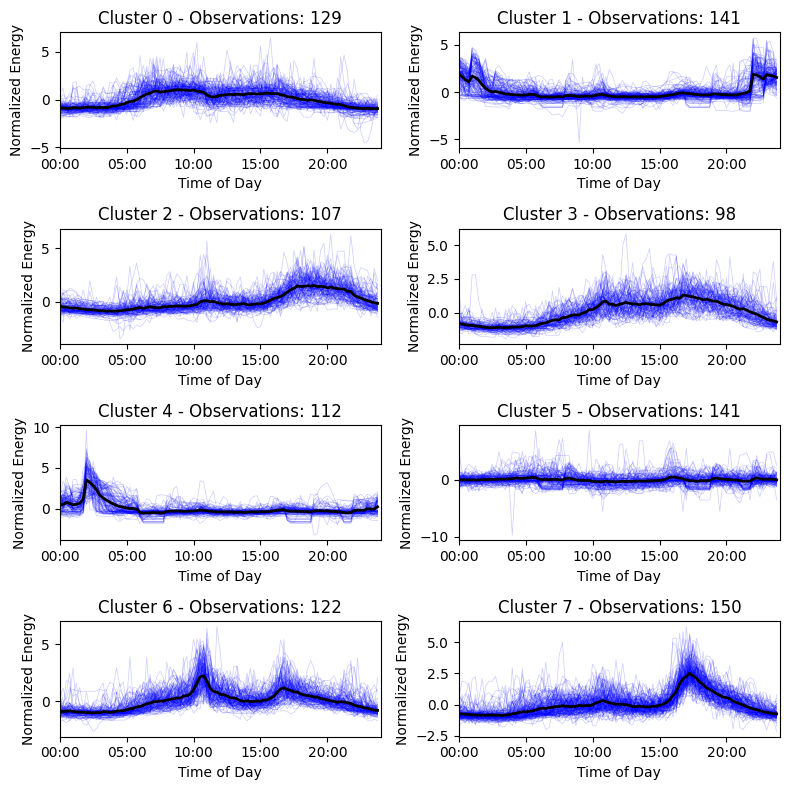

In [ ]:
# extract the data and scale / normalized the profiles
np_scaled = StandardScaler().fit_transform(df_profiles.values)

# define the number of clusters, fit the model to the scaled profiles and predict
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
np_preds = kmeans.fit_predict(np_scaled)

# create the figure
fig, ax = plt.subplots(int(math.ceil(n_clusters/2)), 2, figsize=(8, 8))
ax = ax.flatten()

# to visualize the clusters, loop over the clusters (i.e. unique labels of predictions)
for idx in np.unique(np_preds):

  # get the indices of the elements (rows) that belong to the same cluster
  indices = np.where(np_preds == idx)[0]

  # use the indices to get the relevant profiles
  np_profs = np_scaled[indices, :].T

  # plot all profiles of a cluster and their mean profile
  ax[idx].plot(np_profs, color='blue', alpha=0.2, linewidth=0.5)
  ax[idx].plot(np.mean(np_profs, axis=1), color='black', linewidth=2)

  # adjust additional formatting
  ax[idx].set_ylabel('Normalized Energy')
  ax[idx].set_xlabel('Time of Day')
  ax[idx].set_xticks(ax[idx].get_xticks())
  ax[idx].set_xticklabels(['{:02d}:{:02d}'.format(int(e/4), int(e%4)) for e in ax[idx].get_xticks()])
  ax[idx].set_title('Cluster {} - Observations: {}'.format(idx, len(indices)))
  ax[idx].set_xlim(0, 96)

# show
plt.tight_layout()
plt.show()

**Key Elements:**
- Clusters: There are 8 clusters (Cluster 0 to Cluster 7), each representing a distinct group of households with similar energy consumption patterns.

- Observations: The number of households in each cluster is indicated (e.g., Cluster 0 has 129 households, Cluster 1 has 141 households, etc.).

- Normalized Energy: The y-axis likely represents normalized energy consumption, which means the energy values have been scaled to a standard range for comparison.

- Time of Day: The x-axis represents the time of day, showing how energy consumption varies throughout the day for each cluster.

Cluster Characteristics: Each cluster's plot shows the average daily energy consumption pattern for the households in that cluster. The shape of the curve indicates when energy usage peaks and dips during the day.

- Cluster 0: This cluster has 129 households. The energy consumption pattern shows a specific trend that peaks and dips at certain times of the day.

- Cluster 1: With 141 households, this cluster might show a different pattern, possibly with higher energy usage during certain hours compared to Cluster 0.

- Cluster 2: This cluster has 107 households and may exhibit another distinct energy usage pattern.

- Cluster 3: With 98 households, this cluster might represent a unique energy consumption profile, possibly with lower overall usage or different peak times.

- Cluster 4: This cluster includes 112 households and shows another variation in daily energy usage.

- Cluster 5: With 141 households, this cluster might have a similar or different pattern compared to Cluster 1.

- Cluster 6: This cluster has 122 households and displays a specific energy consumption trend.

- Cluster 7: The largest cluster with 150 households, this group likely has a distinct energy usage pattern that sets it apart from the others.

**Insights:**

- Pattern Recognition: By analyzing the curves, you can identify common energy usage patterns among households. For example, some clusters might show higher energy usage during the morning or evening, indicating typical peak hours.

- Cluster Size: The number of households in each cluster can indicate how common certain energy usage patterns are. Larger clusters (like Cluster 7 with 150 households) represent more common patterns, while smaller clusters (like Cluster 3 with 98 households) might represent more unique or less common behaviors.

- Energy Management: These clusters can help in designing targeted energy-saving strategies. For instance, households in clusters with high peak energy usage might benefit from demand response programs or time-of-use pricing.



# Load Forecasting